<hr style="height:3px;color:red;background-color:gray">
<h1><font style="font-family:courier;"> Prediction of volcanic eruptions from seismic data</font></h1>
<br>
<font style="font-family:courier;">Discover hidden precursors in geophysical data to help emergency response</font>
<br>
<hr style="height:3px;color:red;background-color:gray">

<h2><font style="font-family:courier;">Overview</font></h2>
<br>
<p style='text-align: justify;'>
What if we can predict volcanic eruptions as we predict weather? One correct forecast can save thousands of lives. Scientists, around the globe, are researching so that the systems for predicting such volcanic eruptions become reliable. It will be advantageous to tens of thousands people to cope up with the unavoidable by planning proper and timely evacuations.

In this study we are working on a problem of predicting volcanic eruptions from seismic behaviour so that the response to such disasters can be improved in future occurrences. Several organizations are fighting for this cause, such as NASA, USGS, INGV etc. The main aim of these organizations is to contribute to the understanding of the Earth’s structural & geological behavior while mitigating the associated risks. 

Seismic signals are a great precursor of a volcano that is going to erupt. But the problem with seimic signals is that they are difficult to interpret. In modern systems, eruptions can be predicted some minutes in advance, but they show difficulty in predicting for a longer-term.          
</p>
<br>
<h2><font style="font-family:courier;">Problem statement</font></h2>
<br>
<p style='text-align: justify;'>
INGV (<a href="https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe">through kaggle</a>) has provided us with data which contains measurements taken through seismometers(sensors) planted across different regions in proximity to an active volcano. Measurements are captured at regular interval for 10 minutes across different sensors. Hence, these measurements can be considered as multi variate time series. Each of this multi variate time series is associated with a dependent variable, called <font style="font-family:courier;">time_to_eruption</font> and it denotes time from the end of each 10 minutes to the start of an eruption. The problem is we have no other information about the data: what is the sensor's signals indicating or where they are located with respect to others etc. 
    
Therefore, in this study we have to apply rich feature engineering techniques to draw out as much information, from the time series data, as we can and train predictive machine learning algorithms on top of the data to predict the time of eruption from future seismic data. But the main challenges that involve is the model should have low latency requirements (in seconds or even a few minutes can be allowed), and should be highly precise & accurate since situations like this can’t be ignored and also should not raise false alarms. Since the domain knowledge is so minimal we have to truly rely on cross validation.
</p>
<br>
<h2><font style="font-family:courier;">Data</font></h2>
<br>
<p style='text-align: justify;'>
The Data has been provided by Istituto Nazionale di Geofisica e Vulcanologia (INGV), Italy's National Institute of Geophysics and Volcanology by means of a <a href="https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe">Kaggle competition</a>. The link to the data is given below.  
    
Source : <a href="https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data">Kaggle INGV Volcanic Eruption Prediction Data</a> 
</p>

<h4><font style="font-family:courier;">Importing dependencies</font></h4>

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor
from prettytable import PrettyTable
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
import pickle
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV

In [10]:
#downloaded contents of the downloaded data
data_dir = os.path.join('data','input')
print("The downloaded data contains :")
print(os.listdir(data_dir))

The downloaded data contains :
['sample_submission.csv', 'test', 'train', 'train.csv']


In [11]:
train_dir = os.path.join(data_dir,'train')
train_dir_file_list = os.listdir(train_dir)
print("Number of files in train directory : {}".format(len(train_dir_file_list)))
print()
print("Few files from the train directory :")
print(train_dir_file_list[:5])
print()
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
print("Number of entries in the train.csv : {}".format(train_df.shape[0]))
print("First few contains of train.csv")
train_df.head()

Number of files in train directory : 4431

Few files from the train directory :
['1000015382.csv', '1000554676.csv', '1000745424.csv', '1001461087.csv', '1001732002.csv']

Number of entries in the train.csv : 4431
First few contains of train.csv


,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [12]:
test_dir = os.path.join(data_dir,'test')
test_dir_file_list = os.listdir(test_dir)
print("Number of files in test directory : {}".format(len(test_dir_file_list)))
print()
print("Few files from the test directory :")
print(test_dir_file_list[:5])
print()
sample_submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
print("Number of entries in the sample_submission.csv : {}".format(sample_submission_df.shape[0]))
print("First few contains of sample_submission.csv")
sample_submission_df.head()

Number of files in test directory : 4520

Few files from the test directory :
['1000213997.csv', '100023368.csv', '1000488999.csv', '1001028887.csv', '1001857862.csv']

Number of entries in the sample_submission.csv : 4520
First few contains of sample_submission.csv


,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


<ul style="list-style-type:circle">
    <li> We have two csv files (train.csv, sample_submission.csv) and two folders (train, test)
    <li>The directory train consists of 4431 csv files and it is our training data.
    <li>The train.csv contains two columns: segment_id and time_to_eruption. For each value of the time_to_eruption variable there is associated a particular segment_id and this segment_ids tells for which training data the particular time_to_eruption is.
    <li>In the similar fashion, the test directory contains 4520 test_data and the sample_submission.csv file contains 4520 segment_ids (test data file names) but this time the time_to_eruption values are unknown 

</ul>

Now lets check what those individual csv files in train or test folder contains 

In [13]:
sample_csv_train = pd.read_csv(os.path.join(train_dir,train_dir_file_list[0]))
sample_csv_test = pd.read_csv(os.path.join(test_dir,test_dir_file_list[0]))
with pd.option_context('expand_frame_repr', False):
    print("The few contents of the {} train file :".format(train_dir_file_list[0]))
    print("="*50)
    print(sample_csv_train.head())
    print()
    print("Shape of the sample train csv file is {}".format(sample_csv_train.shape))
    print()
    print("The few contents of the {} test file :".format(test_dir_file_list[0]))
    print("="*50)
    print(sample_csv_test.head())
    print()
    print("Shape of the sample test csv file is {}".format(sample_csv_test.shape))

The few contents of the 1000015382.csv train file :
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10
0     260.0      64.0    -232.0     -36.0      -2.0     -35.0     103.0     389.0      67.0       41.0
1     233.0     175.0     146.0     160.0      -4.0      29.0    -120.0     498.0      59.0       63.0
2     216.0     236.0     321.0     202.0       2.0     113.0    -230.0     554.0      97.0       90.0
3     156.0     205.0     382.0       6.0      12.0      70.0    -228.0     580.0     141.0      122.0
4     158.0     101.0     272.0    -154.0      16.0      45.0    -162.0     624.0     145.0      154.0

Shape of the sample train csv file is (60001, 10)

The few contents of the 1000213997.csv test file :
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10
0     180.0       NaN     295.0    -221.0     -81.0     379.0     240.0    -288.0     152.0        0.0
1     200.0       NaN

So we have total of 60001 readings taken across 10 sensor for each segment. We would now perform a quick check if all the files in train contains 60001 readings, just become sure of whats going on. Also make a note that, there are some sensors which has missed to capture signals for an entire segment (see sensor 2 values from test file)

In [14]:
def return_nrows(file_path):
    """
    The function takes a filepath of a csv file as input
    and returns the number of rows in the particular csv
    """
    sample = pd.read_csv(file_path)
    rows, _ = sample.shape
    return rows

def check_all_train(train_df, train_dir):
    """
    This function is defined to check if the number of rows
    in every csv file in the train directory contains 60001 entries.
    The function takes train_df that contains the segment_ids
    and returns True if all train segment files contains 60001 rows
    """
    all_train_nrows = np.array([])
    for file in tqdm(train_df['segment_id'].values):
        file_path = os.path.join(train_dir, (str(file) + '.csv'))
        all_train_nrows = np.append(all_train_nrows,[True if return_nrows(file_path)==60001 else False])
    print("All the files in train directory contains 60001 entries ",all_train_nrows.all())

In [26]:
check_all_train(train_df, train_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 4431/4431 [06:12<00:00, 11.88it/s]

All the files in train directory contains 60001 entries  True


The multivariate time series data for each segment has been captured at regular intervals for a duration of 10 mins (600 seconds). We have ~60000 readings of each segment id hence we can say the readings has been captured every 100th of a second or every 10 ms. We also have time_to_eruption variable associated with each of the segment ids. This time_to_eruption variable depicts the time duration from end of each 10 mins segment to the start of an eruption. 

In [15]:
print("First few entries of the train csv file")
train_df.head()

First few entries of the train csv file


,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


Since readings are captured every 10 ms (1 centi second), the unit of time_to_eruption should be also cs (centi second/10 ms).
Now, we will take a look at these values and try to convert it into human understandable time scale (hours, minutes) so that we could have some inferences based on it

In [16]:
def ms_hm(value):
    """
    This function will convert from 10-milliseconds(centi second) format to
    hours and minutes.
    """
    no_of_ten_msecs = value
    no_of_msecs = 10 * value
    no_of_secs = int(no_of_msecs/1000)
    no_of_hours = int(no_of_secs/3600)
    no_of_mins = int((no_of_secs % 3600)/60)
    hm ={'hours' : no_of_hours,
         'minutes' : no_of_mins}
    return hm

In [9]:
# for example 
sample_value_1 = 360000 # we know 1 hour = 3600 secs = 360000 centi secs
#here t-msecs is the unit stands for 10 milliseconds
print(ms_hm(sample_value_1))

{'hours': 1, 'minutes': 0}


In [10]:
print("The minimum value of time_to_eruption : {}".format(train_df['time_to_eruption'].min()))
h, m = ms_hm(train_df['time_to_eruption'].min()).values()
print("which is basically {} hours {} minutes".format(h, m))
print()
print("The maximum value of time_to_eruption : {}".format(train_df['time_to_eruption'].max()))
h, m = ms_hm(train_df['time_to_eruption'].max()).values()
print("which is basically {} hours {} minutes".format(h, m))

The minimum value of time_to_eruption : 6250
which is basically 0 hours 1 minutes

The maximum value of time_to_eruption : 49046087
which is basically 136 hours 14 minutes


We can see that the values of time_to_eruption in the given dataset varies from a minimum value of 1 minute to maximum value of ~136 hours, which is roughly equal to 6 days. Let us take a look at distrubution of time_to_eruption. 

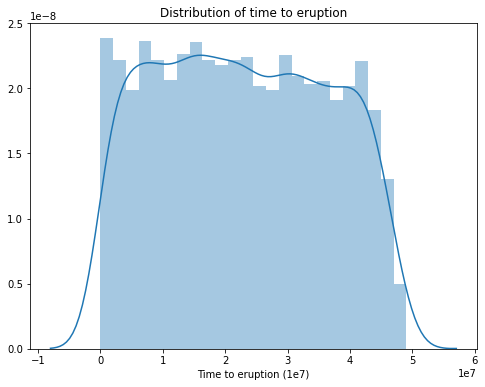

In [11]:
fig, ax =plt.subplots(figsize=(8,6))
tte_dist_plot = sns.distplot(train_df.time_to_eruption, bins=24, ax=ax)
plt.xlabel("Time to eruption (1e7)")
plt.title("Distribution of time to eruption")
plt.show()

In [12]:
avg_binwidth = np.array([i.get_width() for i in tte_dist_plot.patches]).mean()
print("The average bin width of the histogram is {}".format(avg_binwidth))
h, m = ms_hm(avg_binwidth).values()
print("Which in hour-minute format stands {} hrs {} mins ".format(h, m))

The average bin width of the histogram is 2043326.5416666667
Which in hour-minute format stands 5 hrs 40 mins 


* The above time_to_eruption density distribution plot conveys that the distribution is close to a uniform distribution between the minimum(0.0006e7) and maximum(4.9e7) values of the given variable. 

* In the histogram plotting function, we have used 24 bins. Since the time_to_eruption spans roughly from 1 minute to 136 hours(5+ days), the bin width can be considered 6 hours (5 hrs 40 mins to be precise). Meaning the 1st bin consists data whose time_to_eruption variable ranges from (0-6hrs), 2nd bin from (6-12hrs) and so on.

* The number of entries/datapoints (or the density) for the last two bins is relatively less than that of the other bins. So therefore there are fewer (relatively less number of) segments whose time_to_eruption falls on the last 12hrs.


We can now check some the time series data of the segments from each of this bins and try to find some insight from it

<h4><font style="font-family:courier;">Visualization of the multivariate time series</font></h4>

In [17]:
def plot_data_segment(segment_id, time_to_erupt=None, train_data_dir='default', kind='line'):
    """
    The function plots the sensor values of 10 sensors for a given segment.
    This function takes the segment_id as input and plots the data in 10 different subplots.
    time_to_erupt parameter is for displaying the value of the time_to_eruption after plotting the plot
    """
    
    color_list = ['tomato', 'olive', 'teal', 'seagreen', 'peru', 'crimson', 'brown', 'orange', 'magenta', 'mediumslateblue']
    print("Sensor data for segment ", segment_id)
    if train_data_dir == 'default':
        train_data_dir = os.path.join("data", "input", "train")
    
    temp_file = str(segment_id) + '.csv'
    temp_data = pd.read_csv(os.path.join(train_data_dir, temp_file))
    
    if kind=='line':
        temp_data.plot(subplots=True, layout=(5,2), figsize=(20,10),
                       title="Sensor data for segment {}".format(segment_id))
    elif kind=='kde':
        
        fig = plt.figure(figsize=(15,10))

        for i in range(10):
            ax = fig.add_subplot(5,2,i+1)
            ax.set_title('sensor_{}'.format(i+1), y=-0.01)
            if not temp_data['sensor_{}'.format(i+1)].isna().all(): 
                temp_data['sensor_{}'.format(i+1)].plot.kde(ax=ax, color=color_list[i])
        fig.suptitle("Sensor data for segment {}".format(segment_id))
    
    if time_to_erupt is not None:
        print("Time to erupt : ", time_to_erupt)
        
    plt.show()

Lets start by plotting the data for the segment which has the minimum value for time_to_eruption variable 

Sensor data for segment  601524801
Time to erupt :  6250


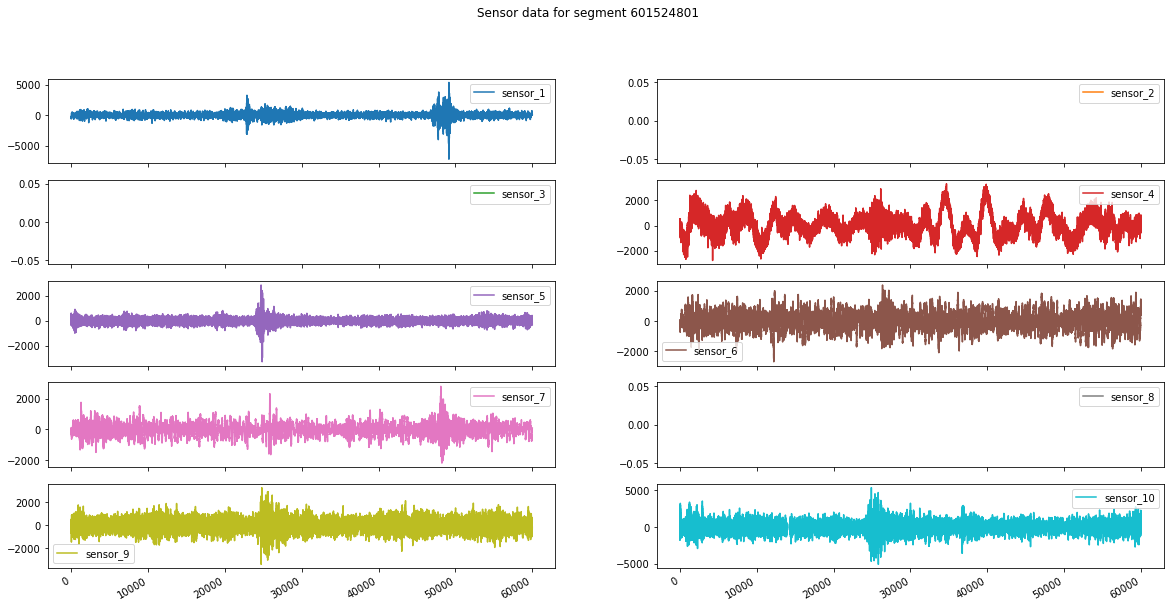

In [14]:
segment_id_min_tte, min_tte = np.squeeze(train_df[train_df['time_to_eruption'] == train_df['time_to_eruption'].min()].values)
# segment_id_min_tte stores the segment id with minimum time_to_eruption
plot_data_segment(segment_id_min_tte, min_tte)

The plot above is a visualization of the sensor values of segment with smallest time_to_eruption (6250 or ~1 minute) value

* in all the sensors, at 4th minute [~25000] (of the total 10 min span of recording) there consists some sudden spikes in most of the sensors.

* there are also spikes seen at the 8th minute[~50000] in sensor 1 and sensor 7

* sensor 4 is has captured some critical tremours.

* The sensors 2, 3 and 8 has entirely missed to capture anything. This missingness can be purely coincidence dur to technical fault or have some hidden pattern.

The pdf of the sensor signals for the particular segment is given below

Sensor data for segment  601524801
Time to erupt :  6250


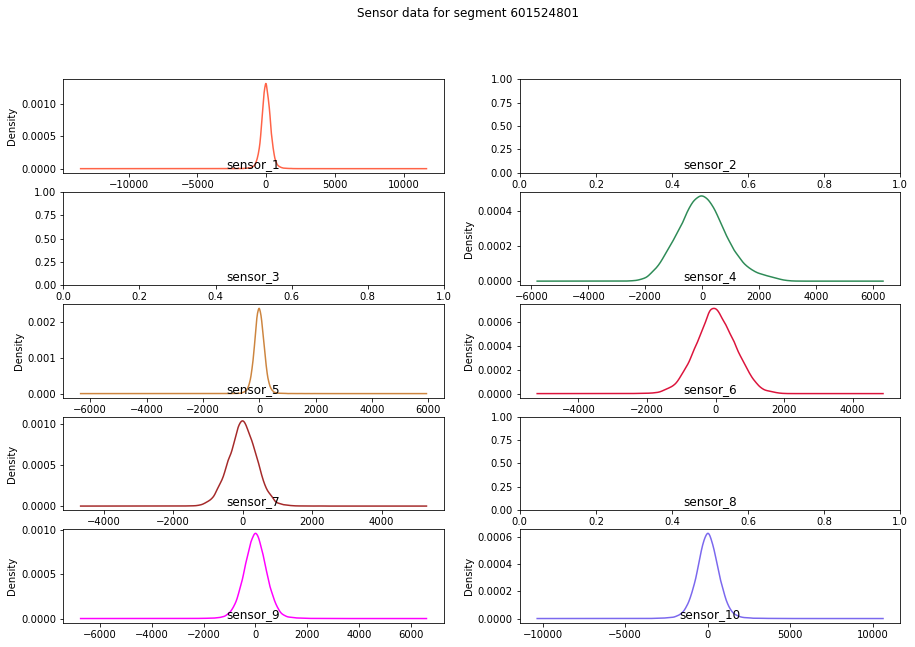

In [15]:
plot_data_segment(segment_id_min_tte, min_tte, kind='kde')

* The above plot depicts the density distribution of each individual sensors for a segment with lowest value for time_to_eruption.
* The sensor readings (as visually interpreted) are very similar to normal distributions. We keep this obeservation in mind.
* We will also check sensor density distribution for other segments as well and if they too are characterized as normal distribution (visually first then after that with some statical technique such as KS test)

We have also seen that there are test segments which consists some entirely missed sensor columns. We will now try to find out which sensors missed entirely for a particular segment.

In [18]:
def return_missed_sensors_info(segment_id_list):
    """
    This function takes a list of segment ids and creates a pandas dataframe,
    which has 10 columns (plus segment id column) for each of the 10 sensors.
    It stores 1 if the particular sensor has entirely missed to capture data 
    for the corresponding segment and stores zero otherwise.
    """
    missed_sensors_df = pd.DataFrame(columns=['segment_id'] + ['missed_sensor_{}'.format(i) for i in range(1,11)])
    for each_segment in tqdm(segment_id_list):
        segment_csv_path = os.path.join('data', 'input', 'train', str(each_segment)+'.csv')
        temp_df = pd.read_csv(segment_csv_path)
        missed_sensors = []
        
        for each_sensor in temp_df.columns:
            entries_in_that_sensor = len(temp_df[each_sensor].value_counts())
            if entries_in_that_sensor == 0:
                missed_sensors.append(1)
            else:
                missed_sensors.append(0)
        each_row = [each_segment] + missed_sensors
        missed_sensors_df.loc[len(missed_sensors_df.index)] = each_row
    return missed_sensors_df
        

Now we will look at the information regarding sensors that have missed to capture data for an entire segment. We will use the above defined function, so that we could get the missing sensor info by passing the whole list of segment ids. 

In [18]:
segment_id_list = list(train_df['segment_id'].values)
missed_sensor_df = return_missed_sensors_info(segment_id_list) 

100%|██████████████████████████████████████████████████████████████████████████████| 4431/4431 [06:57<00:00, 10.61it/s]


In [19]:
missed_sensor_df.head()

,segment_id,missed_sensor_1,missed_sensor_2,missed_sensor_3,missed_sensor_4,missed_sensor_5,missed_sensor_6,missed_sensor_7,missed_sensor_8,missed_sensor_9,missed_sensor_10
0,1136037770,0,0,0,0,1,0,0,0,0,0
1,1969647810,0,0,0,0,0,0,0,0,0,0
2,1895879680,0,0,0,0,1,0,0,0,0,0
3,2068207140,0,0,0,0,0,0,0,0,0,0
4,192955606,0,1,0,0,0,0,0,0,0,0


The above few examples of dataframe, we have just created, shows for which sensors have missed to capture for which segment. For example we can see that sensor_5 have entirely missed segment 1136037770. We will plot the frequency distribution of segments wrt each sensors that has failed to capture information. 

In [20]:
sensor_names = list(missed_sensor_df[missed_sensor_df.columns[1:]].sum(axis=0).keys())
missed_values = list(missed_sensor_df[missed_sensor_df.columns[1:]].sum(axis=0).values)

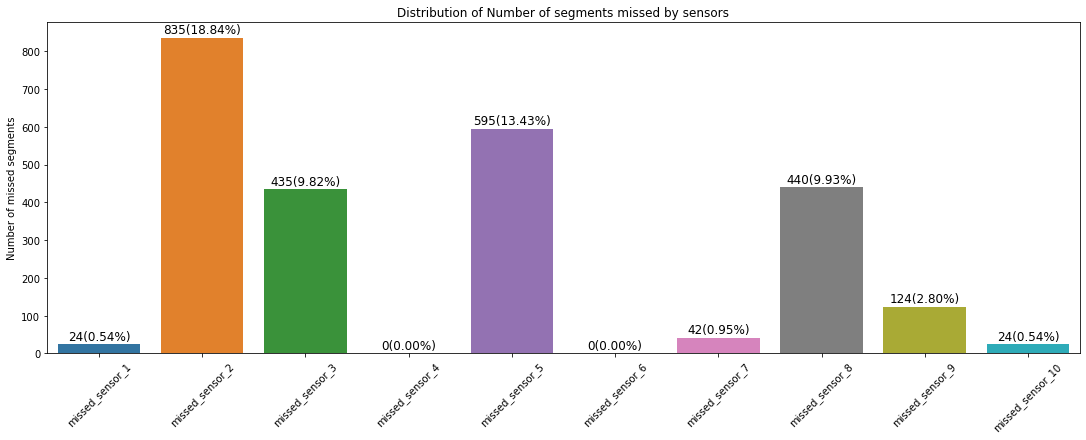

In [21]:
fig, ax =plt.subplots(figsize=(15,6))
missedsensor_plot = sns.barplot(sensor_names,missed_values)

for each_patch in missedsensor_plot.patches: 
  
    missedsensor_plot.annotate("{}({:.2f}%)".format(int(each_patch.get_height()), each_patch.get_height()/44.31), 
                   (each_patch.get_x() + each_patch.get_width() / 2, 
                    each_patch.get_height()), ha='center', va='center', 
                   size=12, xytext=(0, 8), 
                   textcoords='offset points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Number of missed segments")
plt.title("Distribution of Number of segments missed by sensors")


plt.show()

From plot above we can see:
* sensor_2 has missed to capture 18.84 % of segments (835), most no. of segments wrt to other sensors, followed by sensor_5(13.43%), sensor_8(9.93%), sensor_3(9.82%) 

* sensor 1, 7, 9 and 10 has missed fewer segments from the data

* while for sensor 4 and sensor 6 we have data for all the training segments

Lets now check the range of values for each sensors. For this we will find the maximum and minimum values for each sensor across all training segments

In [19]:
def return_sensor_range_dict(segment_id_list):
    """
    This function takes a list of segment ids and returns a dictionary
    of minimum and maximum values for each of the sensors across the 
    given list of segment ids
    """
    
    sensor_name_list = ['sensor_{}'.format(i+1) for i in range(10)]
    sensor_range_list  = [[np.inf,-np.inf] for i in range(10)]
    sensor_range_dict = {sensor_name_list[i] : sensor_range_list[i] for i in range(10)}
    
    for each_segment in tqdm(segment_id_list):
        segment_csv = os.path.join('data', 'input', 'train', str(each_segment) + '.csv')
        segment_df = pd.read_csv(segment_csv)
        
        for each_sensor in segment_df.columns:
            temp_min = segment_df[each_sensor].min()
            temp_max = segment_df[each_sensor].max()
            
            if temp_min < sensor_range_dict[each_sensor][0]:
                sensor_range_dict[each_sensor][0] = temp_min
            
            if temp_max > sensor_range_dict[each_sensor][1]:
                sensor_range_dict[each_sensor][1] = temp_max
    return sensor_range_dict

In [23]:
return_sensor_range_dict(list(train_df['segment_id']))

100%|██████████████████████████████████████████████████████████████████████████████| 4431/4431 [05:01<00:00, 14.68it/s]


{'sensor_1': [-32767.0, 32767.0],
 'sensor_2': [-32767.0, 32767.0],
 'sensor_3': [-32767.0, 32767.0],
 'sensor_4': [-32767.0, 32767.0],
 'sensor_5': [-32767.0, 32767.0],
 'sensor_6': [-32767.0, 32767.0],
 'sensor_7': [-32767.0, 32767.0],
 'sensor_8': [-32767.0, 32767.0],
 'sensor_9': [-32767.0, 32767.0],
 'sensor_10': [-32767.0, 32767.0]}

From the above output we can state that all the sensor values range from -32767 to 32767. And now we will sort the train segments wrt time_to_eruption and analyze some of the segments with low and high values for time_to_eruption

In [20]:
train_df_sorted = train_df.sort_values('time_to_eruption').reset_index(drop=True)
del train_df

Lets plot some of the time series visualization of some segments that has low values for time_to_eruption.

Sensor data for segment  1658693785
Time to erupt :  25730


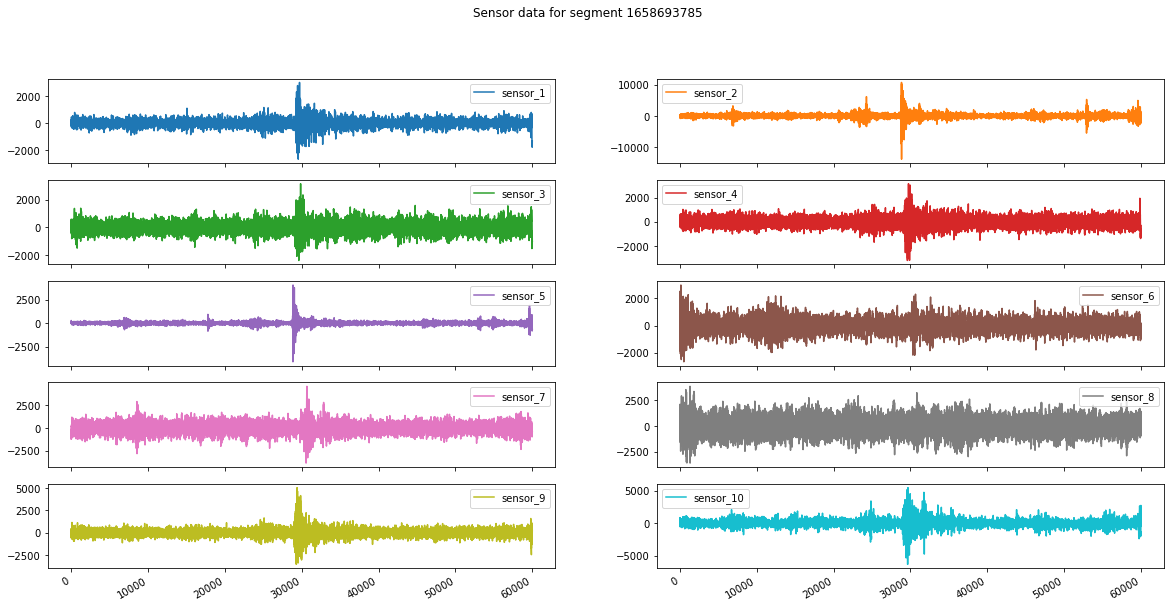

In [25]:
#plotting the sensor signals of the segment with second lowest time_to_eruption
segment_id, tte_of_that_segment = train_df_sorted.loc[1][['segment_id', 'time_to_eruption']]
plot_data_segment(segment_id, tte_of_that_segment)

The plot above is of the segment that whose time_to_eruption is some (4 minutes) in future (wrt time when data was captured). Lets look at another data with a low value for time_to_eruption.

Sensor data for segment  1957235969
Time to erupt :  26929


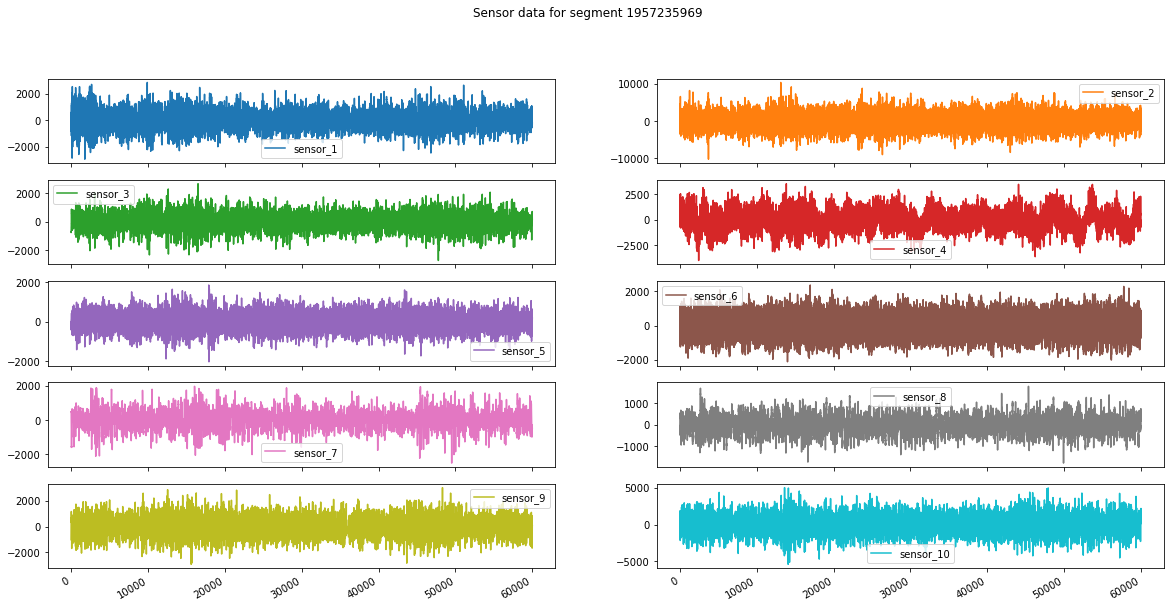

In [26]:
#plotting the sensor signals of the segment with third lowest time_to_eruption
segment_id, tte_of_that_segment = train_df_sorted.loc[2][['segment_id', 'time_to_eruption']]
plot_data_segment(segment_id, tte_of_that_segment)

The above two plots shows the for the 2nd and 3rd segments (2nd and 3rd wrt time_to_eruption) and we can see that:
* the signals in the first plot have major tremors in all the sensors during 30000 cs 
* the signals in the second also have in between 10000 to 20000 cs and 40000 to 50000 cs but in they are not clearly distinguisable as in the first plot.
* This peaks and falls in data could serve as good features for predicting eruption.

Lets look at some other segments that are assigned with higher values of time_to_eruption. We will now plot the data with much larger value for time_to_eruption and check if they can be compared with the above plots (with much much lower time_to_eruption)

Sensor data for segment  1923243961
Time to erupt :  49046087


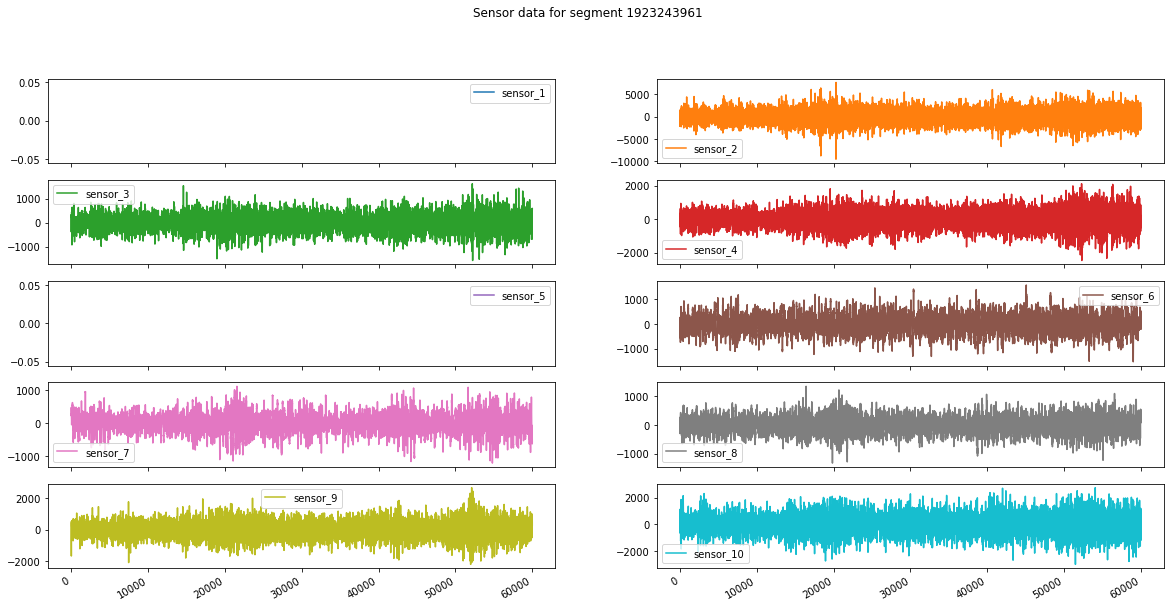

In [27]:
#plotting the sensor signals of the segment with highest time_to_eruption value
segment_id, tte_of_that_segment = train_df_sorted.loc[4430][['segment_id', 'time_to_eruption']]
plot_data_segment(segment_id, tte_of_that_segment)

Sensor data for segment  1552761888
Time to erupt :  48814294


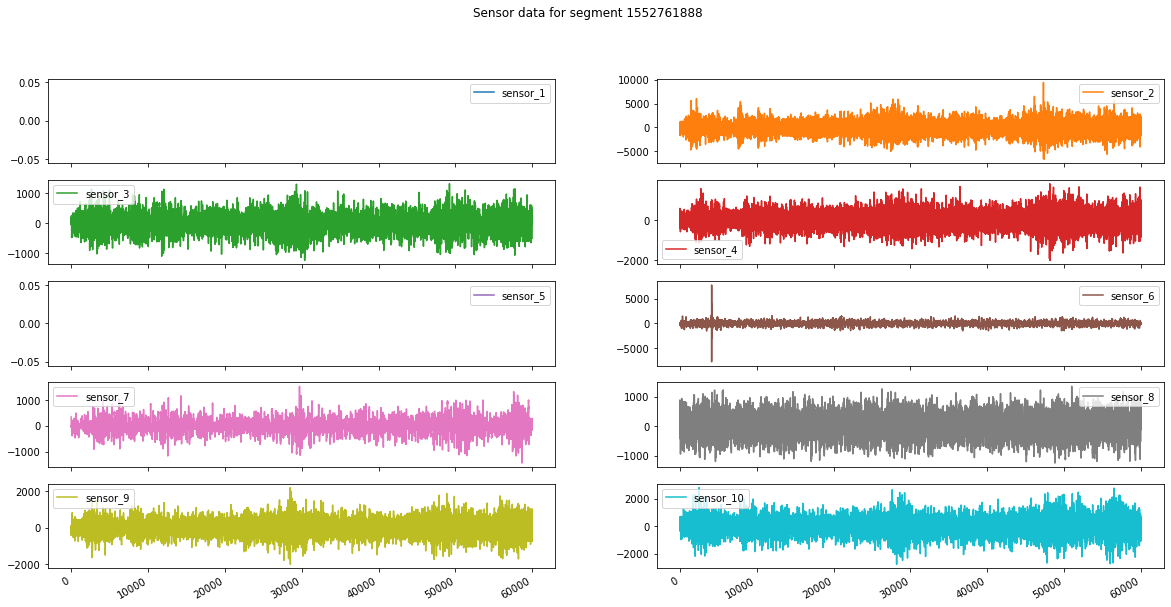

In [28]:
#plotting the sensor signals of the segment with second highest time_to_eruption
segment_id, tte_of_that_segment = train_df_sorted.loc[4429][['segment_id', 'time_to_eruption']]
plot_data_segment(segment_id, tte_of_that_segment)

The two plots above is visualizing the sensor values from the last two segments (wrt time_to_eruption):
* like the segment plot of first few segments these plot also contains peaks and falls
* these plots have one thing common that they both are missed by sensor_1 and sensor_5.

In [22]:
train_df_merged = train_df_sorted.merge(missed_sensor_df, how='left', on='segment_id')

* sensor 1 and sensor 5 has missed to capture the time series for the segments with highest value of time_to_eruption

* the peaks and falls between some particular time interval (in the specified 10 mins) can serve as features for the time series.

* The missing of entire series by some particular sensor or set of sensor could also give indication for time_to_eruption


Now we will plot sensor value density plot of some segments (five basically since all can't be plotted) to check their distribution patterns.

In [30]:
five_sample_segments = train_df_sorted.sample(5, random_state=29).reset_index().drop('index', axis=1)

In [31]:
five_sample_segments

,segment_id,time_to_eruption
0,677960831,28286783
1,1888696517,12493093
2,92198020,17281453
3,785858556,9146209
4,228030886,21649697


Sensor data for segment  677960831
Time to erupt :  28286783


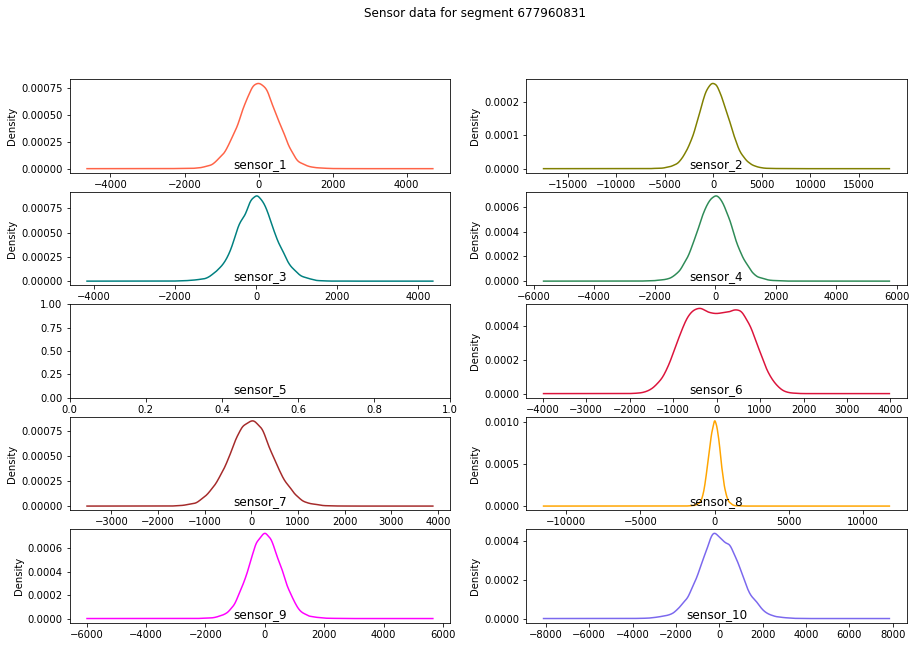

In [32]:
seg_id, tte = five_sample_segments.iloc[0]
plot_data_segment(seg_id, tte, kind='kde')

Sensor data for segment  228030886
Time to erupt :  21649697


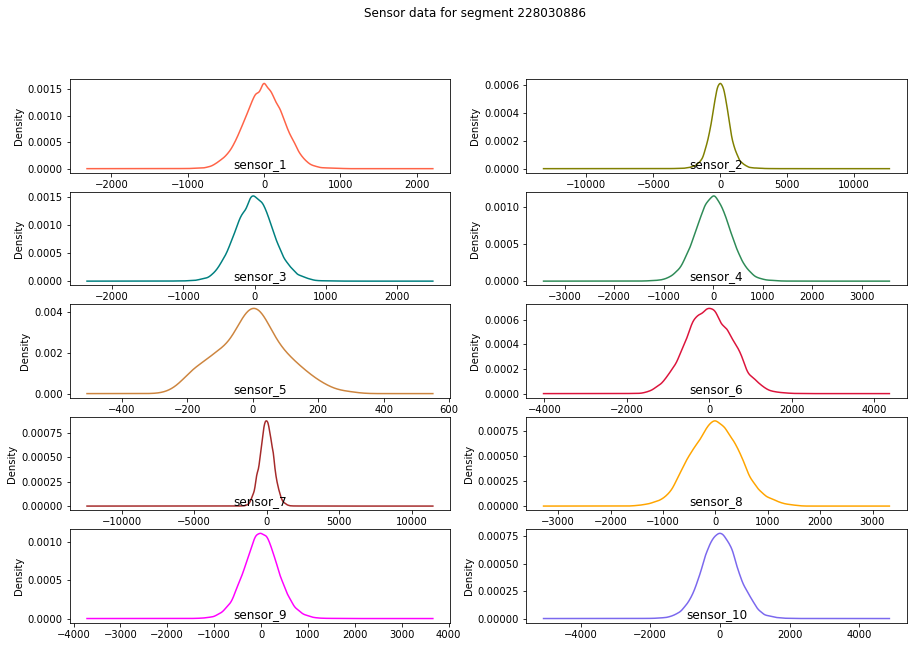

In [33]:
seg_id, tte = five_sample_segments.iloc[-1]
plot_data_segment(seg_id, tte, kind='kde')

Hence from the above two plot we can conclude
* though most of the sensor distribution looks like normal distribution, they are certainly not
* we can confirm it by looking at the distribution of sensors 6 & 10 (of the first plot) and sensors 5 & 6 
* But most them resembles the bell-curve structure of normal distribution. So we consider adding the properties such as mean, standard deviation, various quantile values, as well as skewness and kutosis as features to each segment from the sensor value distribution.

<h2><font style="font-family:courier;">Basic feature engineering</font></h2>

<h3><font style="font-family:courier;">1. Descriptive statistics of each segment</font></h3>


In this section we create some basic descriptive features on the sensor values. This feature includes: mean, standard deviation, minimum, maximum, different quantile values (30th, 60th, 80th, 90th), skewness and kurtosis of the sensor distribution.

In [11]:
def basic_feature_v1(segment_id_list):
    """
    This function takes a list of segment ids and returns a pandas DataFrame
    containing various features of the segments namely mean, standard deviation, different quantile values,
    skewness, kurtosis of different sensor distribution
    """
    
    desc_stat_list = ['mean', 'std', 'min', 'max', '30qt', '60qt', '80qt', '90qt', 'skew', 'kurt']
    columns = ['sensor_{}_'.format(i+1) + fea  for i in range(10) for fea in desc_stat_list]
    
    v1_df = pd.DataFrame(columns= ['segment_id'] + columns)
    
    for each_segment in tqdm(segment_id_list):
        
        seg_csv_path = os.path.join('data', 'input', 'train', str(each_segment)+'.csv')
        seg_df = pd.read_csv(seg_csv_path)
        seg_df = seg_df.fillna(0)
        
        each_row = []
        
        for each_column in seg_df.columns:
            each_row.append(seg_df[each_column].mean())
            each_row.append(seg_df[each_column].std())
            each_row.append(seg_df[each_column].min())
            each_row.append(seg_df[each_column].max())
            each_row.append(seg_df[each_column].quantile(.3))
            each_row.append(seg_df[each_column].quantile(.6))
            each_row.append(seg_df[each_column].quantile(.8))
            each_row.append(seg_df[each_column].quantile(.9))
            each_row.append(seg_df[each_column].skew())
            each_row.append(seg_df[each_column].kurt())
        
            
        v1_df.loc[len(v1_df.index)] = [each_segment] + each_row
        
        v1_df = v1_df.astype({'segment_id' : 'int32'})
    
    return v1_df  
            

In [12]:
train_v1_df = basic_feature_v1(list(train_df_sorted['segment_id']))

100%|██████████████████████████████████████████████████████████████████████████████| 4431/4431 [12:36<00:00,  5.85it/s]


In [ ]:
train_df_v1_merged = train_df_sorted.merge(train_v1_df, how='left', on='segment_id')
del train_df_merged, train_df_sorted, train_v1_df

In [14]:
train_df_v1_merged.head()

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_max,sensor_1_30qt,sensor_1_60qt,sensor_1_80qt,sensor_1_90qt,...,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_max,sensor_10_30qt,sensor_10_60qt,sensor_10_80qt,sensor_10_90qt,sensor_10_skew,sensor_10_kurt
0,601524801,6250,3.592257,376.354555,-7201.0,5381.0,-157.0,79.0,269.0,423.0,...,-0.906685,715.795412,-5100.0,5377.0,-327.0,151.0,541.0,852.0,0.000300,2.439685
1,1658693785,25730,0.083549,311.797088,-2673.0,3016.0,-135.0,66.0,225.0,349.0,...,3.804337,650.590983,-6308.0,5441.0,-261.0,127.0,435.0,676.0,-0.115138,8.651585
2,1957235969,26929,4.025400,654.140307,-2948.0,2848.0,-331.0,157.0,547.0,834.0,...,13.481109,1252.844243,-5433.0,5037.0,-641.0,318.0,1058.0,1623.0,0.013201,0.132980
3,442994108,28696,1.024150,240.529947,-1017.0,1050.0,-121.0,58.0,199.0,310.0,...,-0.343578,368.367031,-2000.0,2136.0,-180.0,87.0,295.0,456.0,-0.011652,0.821537
4,1626437563,40492,-2.370710,507.330676,-2181.0,2332.0,-259.0,124.0,412.0,638.0,...,10.562441,1048.560741,-4471.0,4132.0,-521.0,251.0,870.0,1358.0,-0.003856,0.277943


<h3><font style="font-family:courier;">Correlation coefficient plot</font></h3>

We will now look into correlation stat of the features with respect to the target variable time_to_eruption

In [38]:
#keeping the data in X(predictors) and y(target) for convinience
independent_columns = [i for i in train_df_v1_merged.columns if i not in ['segment_id', 'time_to_eruption']]
dependent_column = ['time_to_eruption']
X, y = train_df_v1_merged[independent_columns], np.squeeze(train_df_v1_merged[dependent_column].to_numpy())

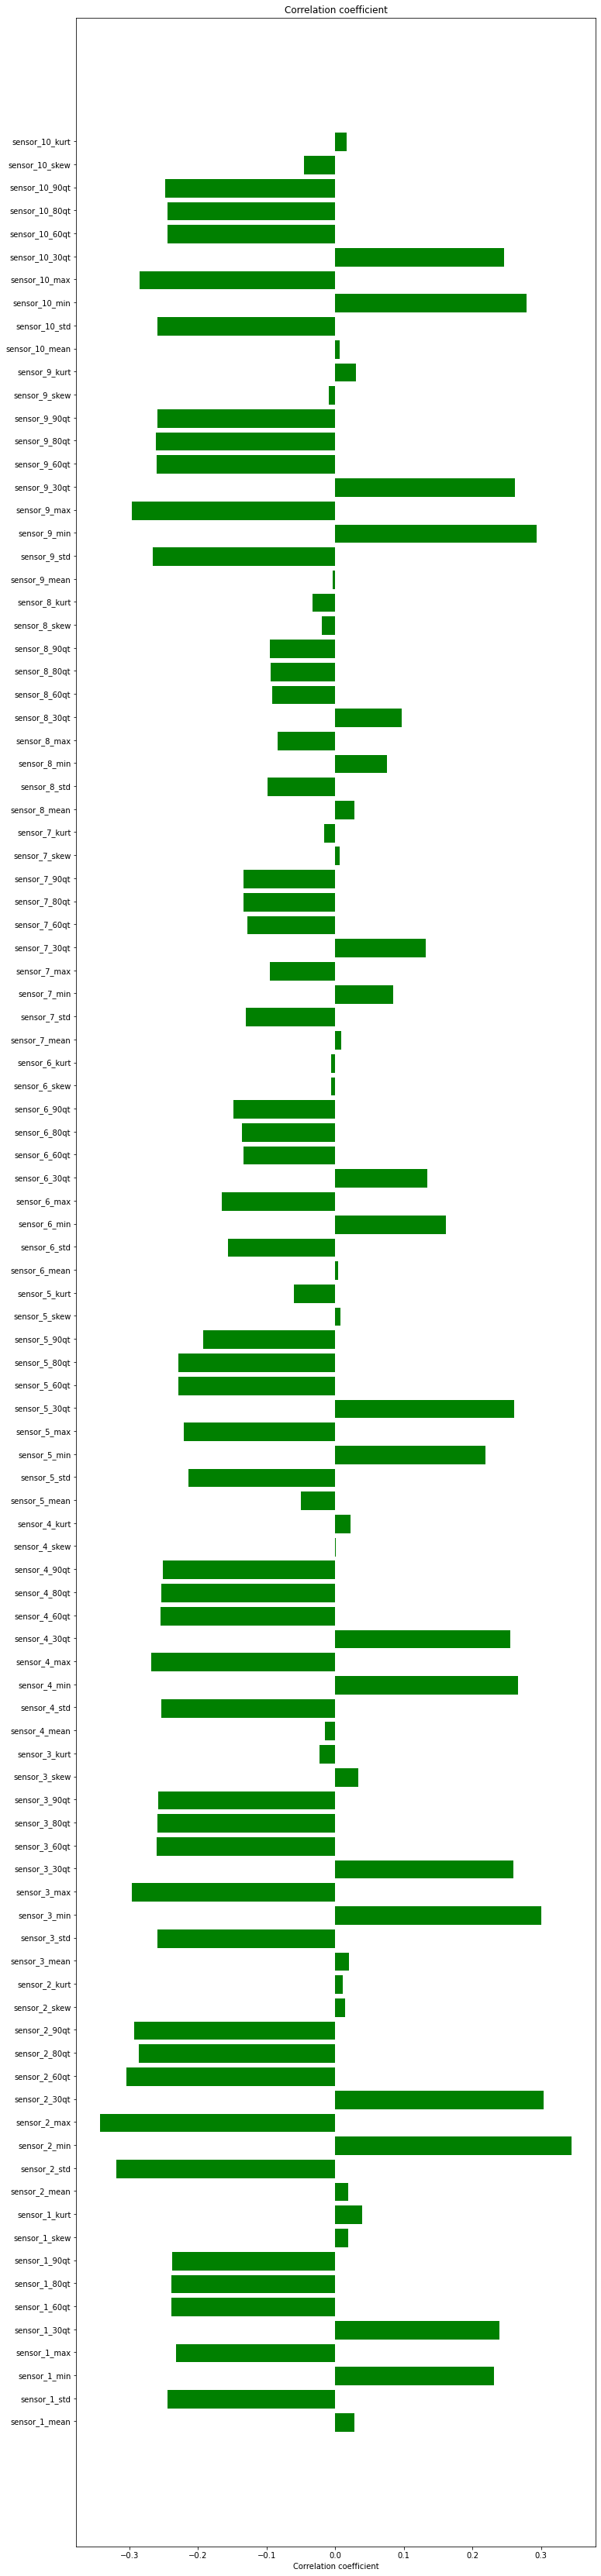

In [39]:
values = []
for each_column in independent_columns:
    values.append(np.corrcoef(X[each_column].values, y)[0,1])

fig, ax = plt.subplots(figsize=(12,60))
indices = np.arange(len(independent_columns))
bars = ax.barh(indices, np.array(values), color='g')

ax.set_yticks(indices+(.04))
ax.set_yticklabels(independent_columns)
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
plt.show()
#Ref:https://www.kaggle.com/sudalairajkumar/univariate-analysis-regression-lb-0-006

The above plot depicts the correlation between the features and the target variable.
* All the basic features, some with higher degree some with lower degree, are correlated (positively or negatively).
* Features describing minimum and 30th quantile of all the sensors are positively correlated with the time_to_eruption variable
* Features describing standard deviation, maximum, quantile(60th, 80th, 90th) values of all the sensors are negatively associated with the target
* For some features mean, skew and kurtosis of each sensor distribution, the correlation magnitude are very low.
* Next we look at the relative feature importances as described by the sklearn's RandomForestRegressor

<h3><font style="font-family:courier;">Relative feature importance plot</font></h3>

The relative feature importance of the drawn features is given by the plot below. The feature importances are calculated by the RandomForest algorithm.

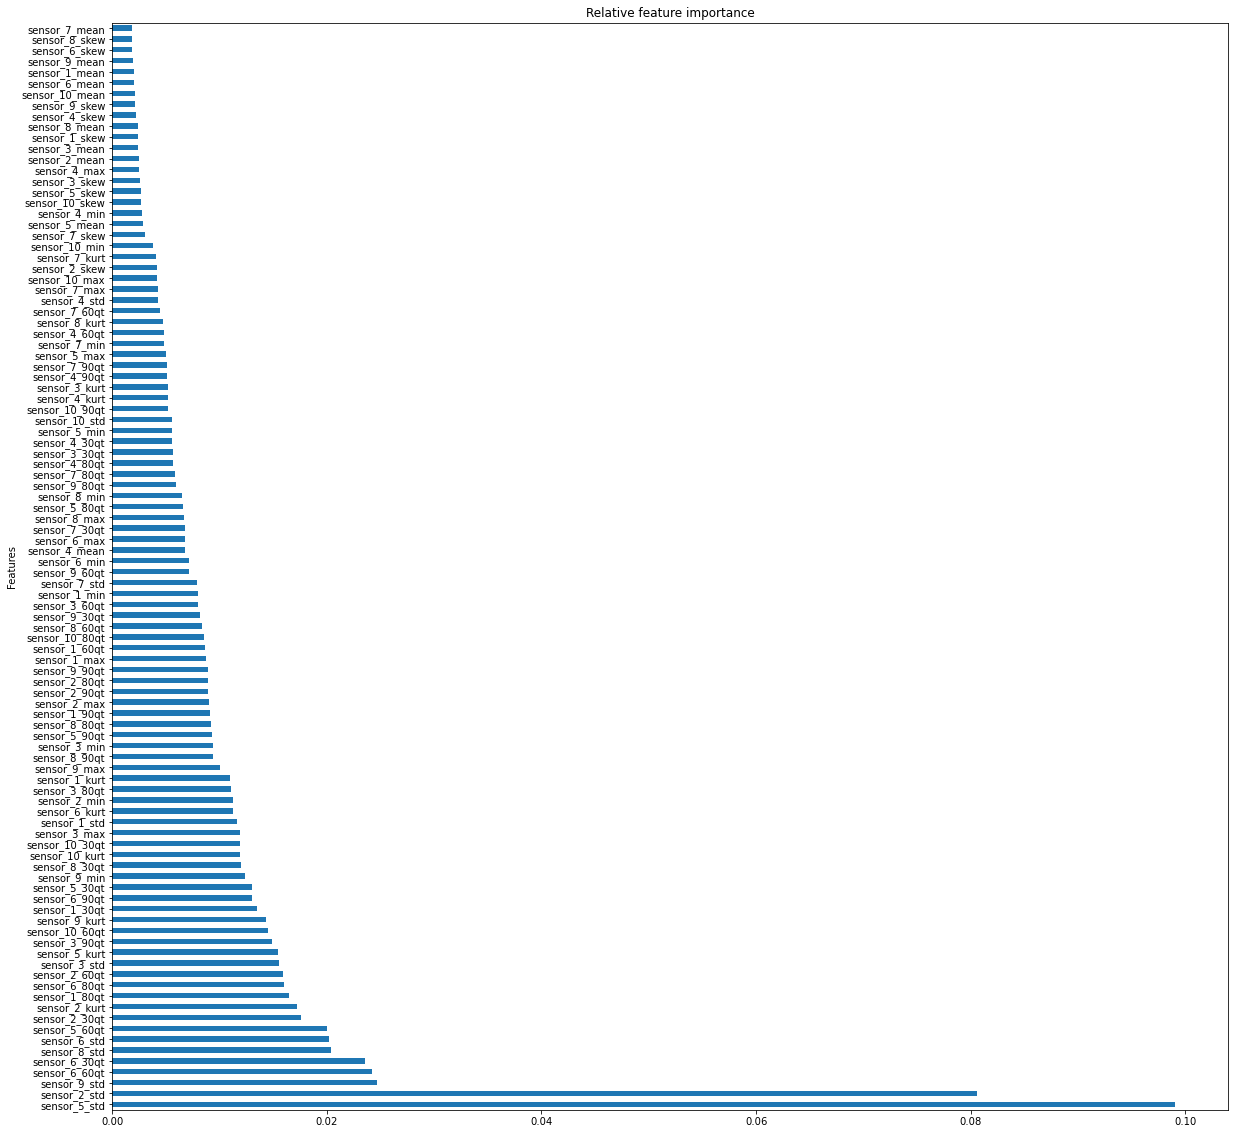

In [40]:
regressor_model = RandomForestRegressor(n_estimators=200)
regressor_model.fit(X,y)
fig, ax = plt.subplots(figsize=(20,20))
pd.Series(regressor_model.feature_importances_, index=X.columns).nlargest(100).plot(kind='barh', ax=ax)
plt.ylabel("Features")
plt.title("Relative feature importance")
plt.show()

The plot above describes the feature importance(relative) wrt RF regressor(with 200 base learners)
* The standard deviation of the sensor_2 and sensor_5 has much higher importance than rest of the features.
* Majority the skewness and mean features has relatively very low importance.
* Since most these features has some degree of importance we can try these features for designing our benchmark model.
* But this time we will discard the mean and skewness features of the given sensor distribution

Since we are keeping track of the min and max of each sensor through each segment, thus we don't need to record missed sensors as it will be a reduntent information.
We have imputed the missing values with zero, so for entirely missed segment by any sensor will a zero in min as well as in max features. 


<h4><font style="font-family:courier;">Creating desprictive features</font></h4>

standard deviation, min, max, (30th, 60th , 80th, 90th) quantile values and the kurtosis of each sensor distribution  

In [15]:
def basic_feature_v2(segment_id_list, test=False):
    """
    This function takes a list of segment ids and returns a pandas DataFrame
    containing various features of the segments namely standard deviation, different quantile values,
    kurtosis of different sensor distribution
    
    Same as v1 but with some minor changes:
    * features namely mean and skewness are not included
    * an option (test) to choose between train/test data has includes
    """
    
    target = 'train' if not test else 'test'
    
    desc_stat_list = ['std', 'min', 'max', '30qt', '60qt', '80qt', '90qt', 'kurt']
    columns = ['sensor_{}_'.format(i+1) + fea  for i in range(10) for fea in desc_stat_list]
    
    v2_df = pd.DataFrame(columns= ['segment_id'] + columns)
    
    for each_segment in tqdm(segment_id_list):
        
        seg_csv_path = os.path.join('data', 'input', target, str(each_segment)+'.csv')
        seg_df = pd.read_csv(seg_csv_path)
        seg_df = seg_df.fillna(0)
        
        each_row = []
        
        for each_column in seg_df.columns:
            #each_row.append(seg_df[each_column].mean()) were included in the above v1 version
            each_row.append(seg_df[each_column].std())
            each_row.append(seg_df[each_column].min())
            each_row.append(seg_df[each_column].max())
            each_row.append(seg_df[each_column].quantile(.3))
            each_row.append(seg_df[each_column].quantile(.6))
            each_row.append(seg_df[each_column].quantile(.8))
            each_row.append(seg_df[each_column].quantile(.9))
            #each_row.append(seg_df[each_column].skew()) were included in the above v1 version
            each_row.append(seg_df[each_column].kurt())
        
            
        v2_df.loc[len(v2_df.index)] = [each_segment] + each_row
        
        v2_df = v2_df.astype({'segment_id' : 'int32'})
    
    return v2_df

In [11]:
train_df = pd.read_csv(os.path.join('data','input', 'train.csv'))
train_df.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [12]:
X, y = train_df['segment_id'], train_df['time_to_eruption'].values
basic_feature_v2_file = os.path.join('data', 'output', 'segBFv2.csv')

try:
    X = pd.read_csv(basic_feature_v2_file)
except:
    X = basic_feature_v2(X.values)
    X.to_csv(basic_feature_v2_file, index=False)


## <h3><font style="font-family:courier;">Machine learning models on basic descriptive features</font></h3>

The first set of features for given segments has drawn out. In this section we incorporate various ML models and check the usefullness of the drawn features.

<h4><font style="font-family:courier;">i) Elastic Net</font></h4>
<hr>

In [6]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [46]:
#standardizing data
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_cv_scaled = std_scaler.transform(X_cv)

The MAE for alpha = 1e-06 is 10568967.435350744
The MAE for alpha = 1e-05 is 10663178.552787712
The MAE for alpha = 0.0001 is 10571709.104069486
The MAE for alpha = 0.001 is 10921456.437695425
The MAE for alpha = 0.01 is 10641047.487544155
The MAE for alpha = 0.1 is 10462726.928371264
The MAE for alpha = 1 is 10562790.756516226
The MAE for alpha = 10 is 10898203.960887644
The MAE for alpha = 100 is 11297572.725494344


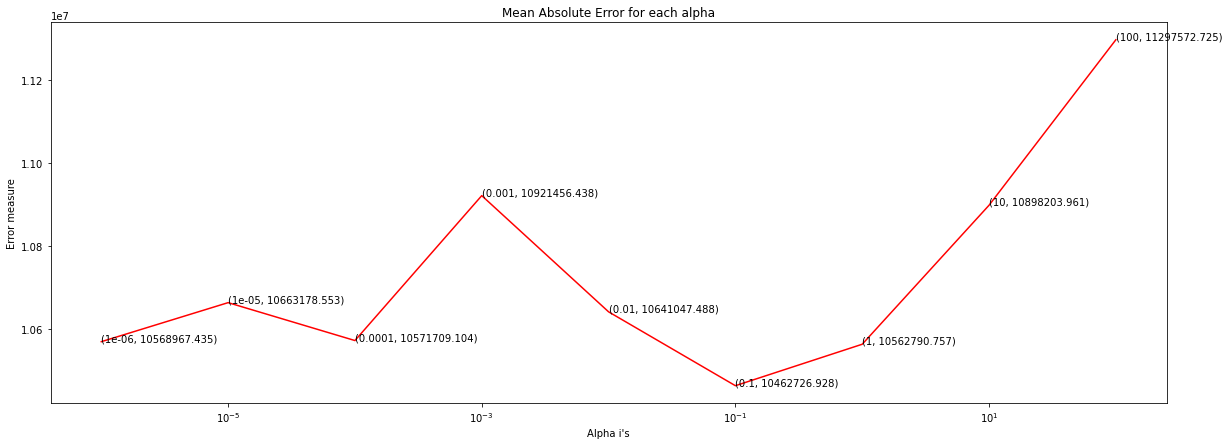

With alpha = 0.1 the best MAE score we get :
Mean Absolute Error for train data :  10327854.391669298
Mean Absolute Error for cv data :  10470667.968969407


In [55]:
alphas = [10**i for i in range(-6, 3)]
cv_mae_list = []
for each_alpha in alphas:
    en_regr = ElasticNet(l1_ratio=0.6, max_iter=5000, selection='random',tol=1, alpha=each_alpha)
    en_regr.fit(X_train_scaled, y_train)
    preds = en_regr.predict(X_cv_scaled)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for alpha = {} is {}".format(each_alpha, error))

best_alpha = alphas[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(alphas, cv_mae_list, c='r')
ax.set_xscale('log')
for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((alphas[i], txt), (alphas[i], cv_mae_list[i]))
plt.title("Mean Absolute Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

elastic_net_regr = ElasticNet(l1_ratio=0.6, tol=1, max_iter=5000, selection='random', alpha=best_alpha)
elastic_net_regr.fit(X_train_scaled, y_train)
train_preds = elastic_net_regr.predict(X_train_scaled)
cv_preds = elastic_net_regr.predict(X_cv_scaled)
print("With alpha = {} the best MAE score we get :".format(best_alpha))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">ii) Random Forest Regressor</font></h4>
<hr>

In [57]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

The MAE for n_estimator = 100 is 4521426.151380866
The MAE for n_estimator = 200 is 4510289.618659747
The MAE for n_estimator = 300 is 4487477.787931709
The MAE for n_estimator = 400 is 4500767.022087093
The MAE for n_estimator = 500 is 4485309.8172138985
The MAE for n_estimator = 600 is 4486561.017422534
The MAE for n_estimator = 700 is 4502572.131162326
The MAE for n_estimator = 800 is 4492870.6169675095
The MAE for n_estimator = 900 is 4482214.842337545
The MAE for n_estimator = 1000 is 4476656.339261733


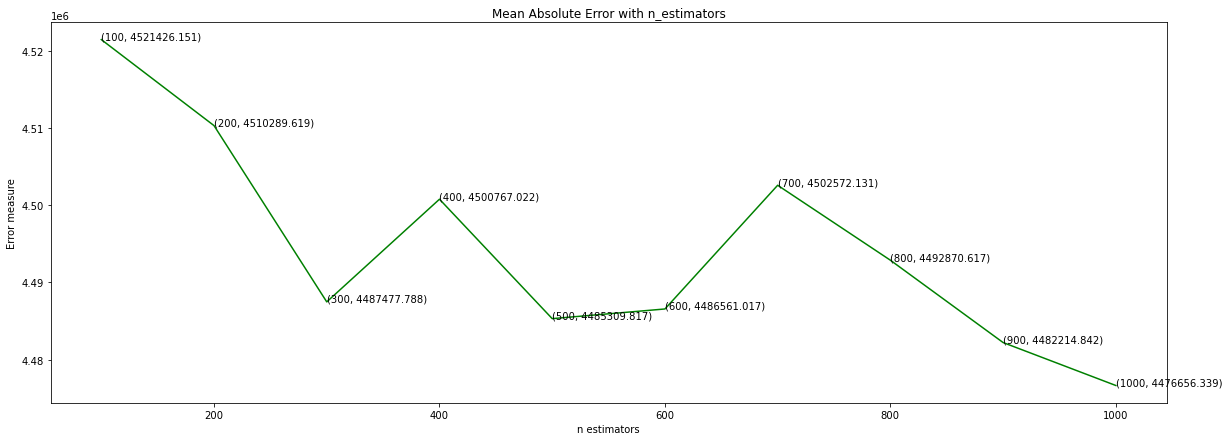

With number of base learners = 1000 the best MAE score we get :
Mean Absolute Error for train data :  1625445.1421757448
Mean Absolute Error for cv data :  4454705.516694946


In [63]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    rf_regr = RandomForestRegressor(n_estimators=each_n_est, criterion='mae', n_jobs=-1)
    rf_regr.fit(X_train, y_train)
    preds = rf_regr.predict(X_cv)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

random_forest_regr = RandomForestRegressor(n_estimators=best_n_estimator, criterion='mae', n_jobs=-1)
random_forest_regr.fit(X_train, y_train)
train_preds = random_forest_regr.predict(X_train)
cv_preds = random_forest_regr.predict(X_cv)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">iii) XGBoost Regressor</font></h4>
<hr>

In [65]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

The MAE for n_estimator = 100 is 4642375.909521661
The MAE for n_estimator = 200 is 4608587.934453971
The MAE for n_estimator = 300 is 4605086.845830043
The MAE for n_estimator = 400 is 4604752.528366144
The MAE for n_estimator = 500 is 4604548.580987703
The MAE for n_estimator = 600 is 4604534.272027302
The MAE for n_estimator = 700 is 4604530.6479157265
The MAE for n_estimator = 800 is 4604531.033174921
The MAE for n_estimator = 900 is 4604529.466112928
The MAE for n_estimator = 1000 is 4604529.352782322


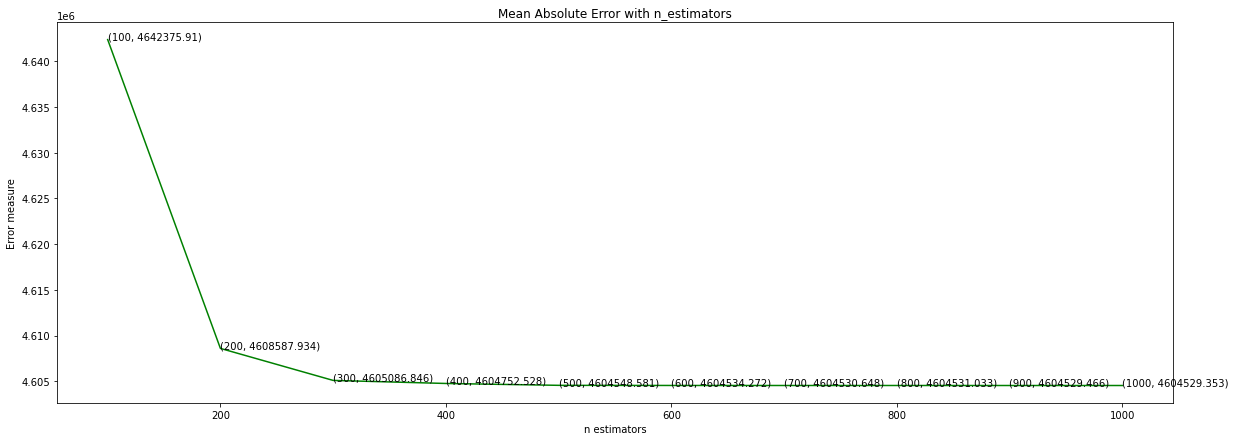

With number of base learners = 1000 the best MAE score we get :
Mean Absolute Error for train data :  3.194096278541604
Mean Absolute Error for cv data :  4604529.352782322


In [67]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    xgb_regr = XGBRegressor(n_estimators=each_n_est, nthread=-2)
    xgb_regr.fit(X_train, y_train)
    preds = xgb_regr.predict(X_cv)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

xg_boost_regr = XGBRegressor(n_estimators=best_n_estimator, nthread=-2)
xg_boost_regr.fit(X_train, y_train)
train_preds = xg_boost_regr.predict(X_train)
cv_preds = xg_boost_regr.predict(X_cv)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

In [16]:
x = PrettyTable()
x.field_names = ['Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['ElasticNet', 10327854.3917, 10470667.9690],
    ['RandomForest', 1625445.1422, 4454705.5167],
    ['XGBoost', 3.1941, 4604529.3528]])
print("Summary of ML models :")
print("="*20)
print(x)

Summary of ML models :
+--------------+---------------+----------------+
|    Model     |   train_mae   | validation_mae |
+--------------+---------------+----------------+
|  ElasticNet  | 10327854.3917 |  10470667.969  |
| RandomForest |  1625445.1422 |  4454705.5167  |
|   XGBoost    |     3.1941    |  4604529.3528  |
+--------------+---------------+----------------+


* Both the XGBoost and RandomForest performs better than ElasticNet in terms of validation_mae, but they both overfits the training data
* The RandomForest in that case performs better than the XGBoost, as XGBoost regressor had highly overfit the train set and also the validation_mae is also higher than RF model
* We will now, therefore, proceed with hyperparamter tuning of the Random Forest Model using RandomSearchCV and try so that it does not overfit.

<h4><font style="font-family:courier;">Hyperparameter Tuning Random Forest Model</font></h4>
<hr>

In [13]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [7]:
rf_regr = RandomForestRegressor(criterion='mae')
prams={
    'n_estimators' : [i for i in range(800, 2000, 100)],
    'max_depth' : [i for i in range(5,20)],
    'min_samples_split' : [i for i in range(10,20)],
    'min_samples_leaf' : [i for i in range(4,12)],
    'max_features' : [0.1*i for i in range(5, 10)],
    'max_samples' : [0.1*i for i in range(5, 10)]
}
cv = RepeatedKFold(n_repeats=2)
random_search_cv=RandomizedSearchCV(rf_regr, param_distributions=prams, cv=cv,verbose=10, n_jobs=3,)
random_search_cv.fit(X_train_fs, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 13.9min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 25.5min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 60.9min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 97.5min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 120.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 142.6min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 164.8min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 208.2min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 240.0min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 262.0min finished


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fractio...
                                

In [10]:
random_search_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=12, max_features=0.6000000000000001,
                      max_leaf_nodes=None, max_samples=0.8,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [19]:
random_forest_regr = random_search_cv.best_estimator_
random_forest_regr.fit(X_train, y_train)
train_preds = random_forest_regr.predict(X_train)
cv_preds = random_forest_regr.predict(X_cv)
print("For hyperparameter tuned RandomForestRegressor with parameters :")
print(random_search_cv.best_params_)
print()
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

For hyperparameter tuned RandomForestRegressor with parameters :
{'n_estimators': 1500, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 0.6000000000000001, 'max_depth': 12}

Mean Absolute Error for train data :  4383116.024559133
Mean Absolute Error for cv data :  5500394.4091687715


In [16]:
with open('rf_model_bfv2.pkl', 'wb') as f:
    pickle.dump(random_forest_regr, f)

<h4><font style="font-family:courier;">Hyperparameter Tuning XGBoost Model</font></h4>
<hr>

In [13]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [16]:
xgb_regr = XGBRegressor()
prams={
    'learning_rate':[i*0.01 for i in range(1,30,2)],
    'n_estimators' : [i for i in range(800, 2000, 100)],
    'max_depth' : [i for i in range(5,20)],
    'colsample_bytree':[i*0.1 for i in range(4,11)],
    'subsample':[i*0.1 for i in range(4,11)]
}

cv = RepeatedKFold(n_repeats=2)
random_search_cv=RandomizedSearchCV(xgb_regr, param_distributions=prams, cv=cv,verbose=10, n_jobs=3,)
random_search_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  8.0min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 11.7min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 13.6min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 14.6min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 18.5min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 19.4min finished


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_chil...
                                                          0.13, 0.15, 0.17,
                                                          0.19, 0.21, 0.23,
                                                          0.25, 0.27, 0.29],
                           

In [17]:
import pickle
with open(os.path.join('model','xgb_model_bfv2.pkl'), 'wb') as f:
    pickle.dump(random_search_cv, f)

In [18]:
xgboost_regr = random_search_cv.best_estimator_
xgboost_regr.fit(X_train, y_train)
train_preds = xgboost_regr.predict(X_train)
cv_preds = xgboost_regr.predict(X_cv)
print("For hyperparameter tuned XGBoostRegressor with parameters :")
print(random_search_cv.best_params_)
print()
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

For hyperparameter tuned XGBoostRegressor with parameters :
{'subsample': 0.4, 'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Mean Absolute Error for train data :  19707.49871692089
Mean Absolute Error for cv data :  4116339.266495798


In [9]:
x = PrettyTable()
x.field_names = ['Feature Set','Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['','ElasticNet', 10327854.3917, 10470667.9690],
    ['','RandomForest', 1625445.1422, 4454705.5167],
    ['Desc stats','XGBoost', 3.1941, 4604529.3528],
    ['', 'HPT Random Forest', 4356897.9917,5467757.9835],
    ['', 'HPT XGBoost', 19707.4987, 4116339.2665]
])
print("Summary of ML models :")
print("="*20)
print(x)
print()
print()
print("Note: HPT = hyperparameter Tuned")

Summary of ML models :
+-------------+-------------------+---------------+----------------+
| Feature Set |       Model       |   train_mae   | validation_mae |
+-------------+-------------------+---------------+----------------+
|             |     ElasticNet    | 10327854.3917 |  10470667.969  |
|             |    RandomForest   |  1625445.1422 |  4454705.5167  |
|  Desc stats |      XGBoost      |     3.1941    |  4604529.3528  |
|             | HPT Random Forest |  4356897.9917 |  5467757.9835  |
|             |    HPT XGBoost    |   19707.4987  |  4116339.2665  |
+-------------+-------------------+---------------+----------------+


Note: HPT = hyperparameter Tuned


<h3><font style="font-family:courier;">2. Descriptive statistics wrt time steps of each segment </font></h3>

In this section, we will create features similar to number 1 but with slight change. We will first divide the whole segment into six parts (each consisting data belonging to 10000 timesteps), and calculate basic statics (say mean, max, min) of the data in these six parts individually and obtain the features. In simple words, in the previous section for each segment we have created features such min, max, 30th quantile, kurtosis of all the sensors such that we had the final features as sensor_1_min, sensor_2_max etc. In the same way we will create features min_10, min_20, ..., min_60, max_10, max_20,...,max_30 for all the sensors such that we will have senor_1_min_10, sensor_2_min_10,...., sensor_10_kurt_60.


In [89]:
def basic_feature_ts_v1(segment_id_list):
    """
    This function takes a list of segment ids and returns a pandas DataFrame
    containing various features of the segments namely mean, standard deviation, different quantile values,
    skewness, kurtosis wrt different time windows of each sensor distribution
    """ 
    
    desc_stat_list = ["{}_{}".format(i,j) 
                      for i in range(10,70,10)
                      for j in ['mean', 'std', 'min', 'max', '30qt', '60qt', '80qt', '90qt', 'skew', 'kurt']]
    
    columns = ['sensor_{}_{}'.format(i+1, fea)
              for i in range(10)
              for fea in desc_stat_list]
    
    v1_df = pd.DataFrame(columns=['segment_id'] + columns)
    
    for each_segment in tqdm(segment_id_list):
        
        seg_csv_path = os.path.join('data', 'input', 'train', str(each_segment)+'.csv')
        seg_df = pd.read_csv(seg_csv_path)
        seg_df = seg_df.fillna(0)
        
        each_row = []
        
        for each_column in seg_df.columns:
            for i in range(6):
                start = i*10000
                end = (i+1)*10000 if i!=5 else None
                
                each_row.append(seg_df.loc[start:end,:][each_column].mean())
                each_row.append(seg_df.loc[start:end,:][each_column].std())
                each_row.append(seg_df.loc[start:end,:][each_column].min())
                each_row.append(seg_df.loc[start:end,:][each_column].max())
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.3))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.6))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.8))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.9))
                each_row.append(seg_df.loc[start:end,:][each_column].skew())
                each_row.append(seg_df.loc[start:end,:][each_column].kurt())
        
        v1_df.loc[len(v1_df.index)] = [each_segment] + each_row
        
        v1_df = v1_df.astype({'segment_id' : 'int32'})
    return v1_df
                

In [85]:
train_df = pd.read_csv(os.path.join('data','input','train.csv'))
train_df.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [90]:
train_v1_df = basic_feature_ts_v1(train_df['segment_id'].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4431/4431 [31:57<00:00,  2.31it/s]


In [91]:
# final dataframe train_df_v1_merged
train_df_v1_merged = train_df.merge(train_v1_df, how='left', on='segment_id')
del train_df, train_v1_df

<h3><font style="font-family:courier;">Correlation coefficient plot</font></h3>

We will now look into correlation stat of the features with respect to the target variable time_to_eruption

In [92]:
independent_columns = [i for i in train_df_v1_merged.columns if i not in ['segment_id', 'time_to_eruption']]
dependent_column = ['time_to_eruption']
X, y = train_df_v1_merged[independent_columns], np.squeeze(train_df_v1_merged[dependent_column].to_numpy())

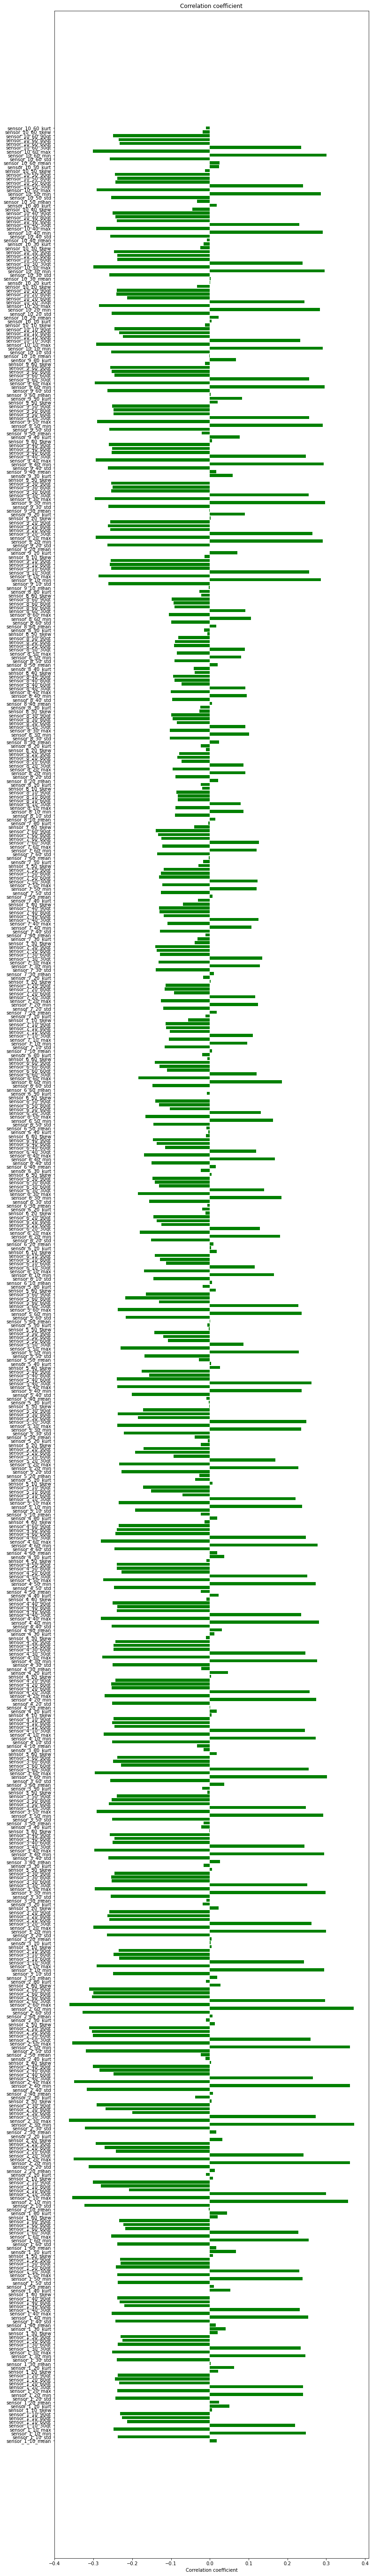

In [93]:
values = []
for each_column in independent_columns:
    values.append(np.corrcoef(X[each_column].values, y)[0,1])

fig, ax = plt.subplots(figsize=(12,100))
indices = np.arange(len(independent_columns))
bars = ax.barh(indices, np.array(values), color='g')

ax.set_yticks(indices+(.04))
ax.set_yticklabels(independent_columns)
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
plt.show()
#Ref:https://www.kaggle.com/sudalairajkumar/univariate-analysis-regression-lb-0-006

The above plot depicts the correlation between the features and the target variable.
* Most of the features, (except features related to mean, kurtosis & skewness) are related with the target variable
* Features such as maximum, standard deviation, quantiles values of 60th, 80th, 90th are negatively correlated with the target
* On the other hand minimum, 30th quantile features are posively correlated.
* Next we look at the relative feature importances as described by the sklearn's RandomForestRegressor

<h3><font style="font-family:courier;">Relative feature importance plot</font></h3>

The relative feature importance of the drawn features is given by the plot below. The feature importances are calculated by the RandomForest algorithm.

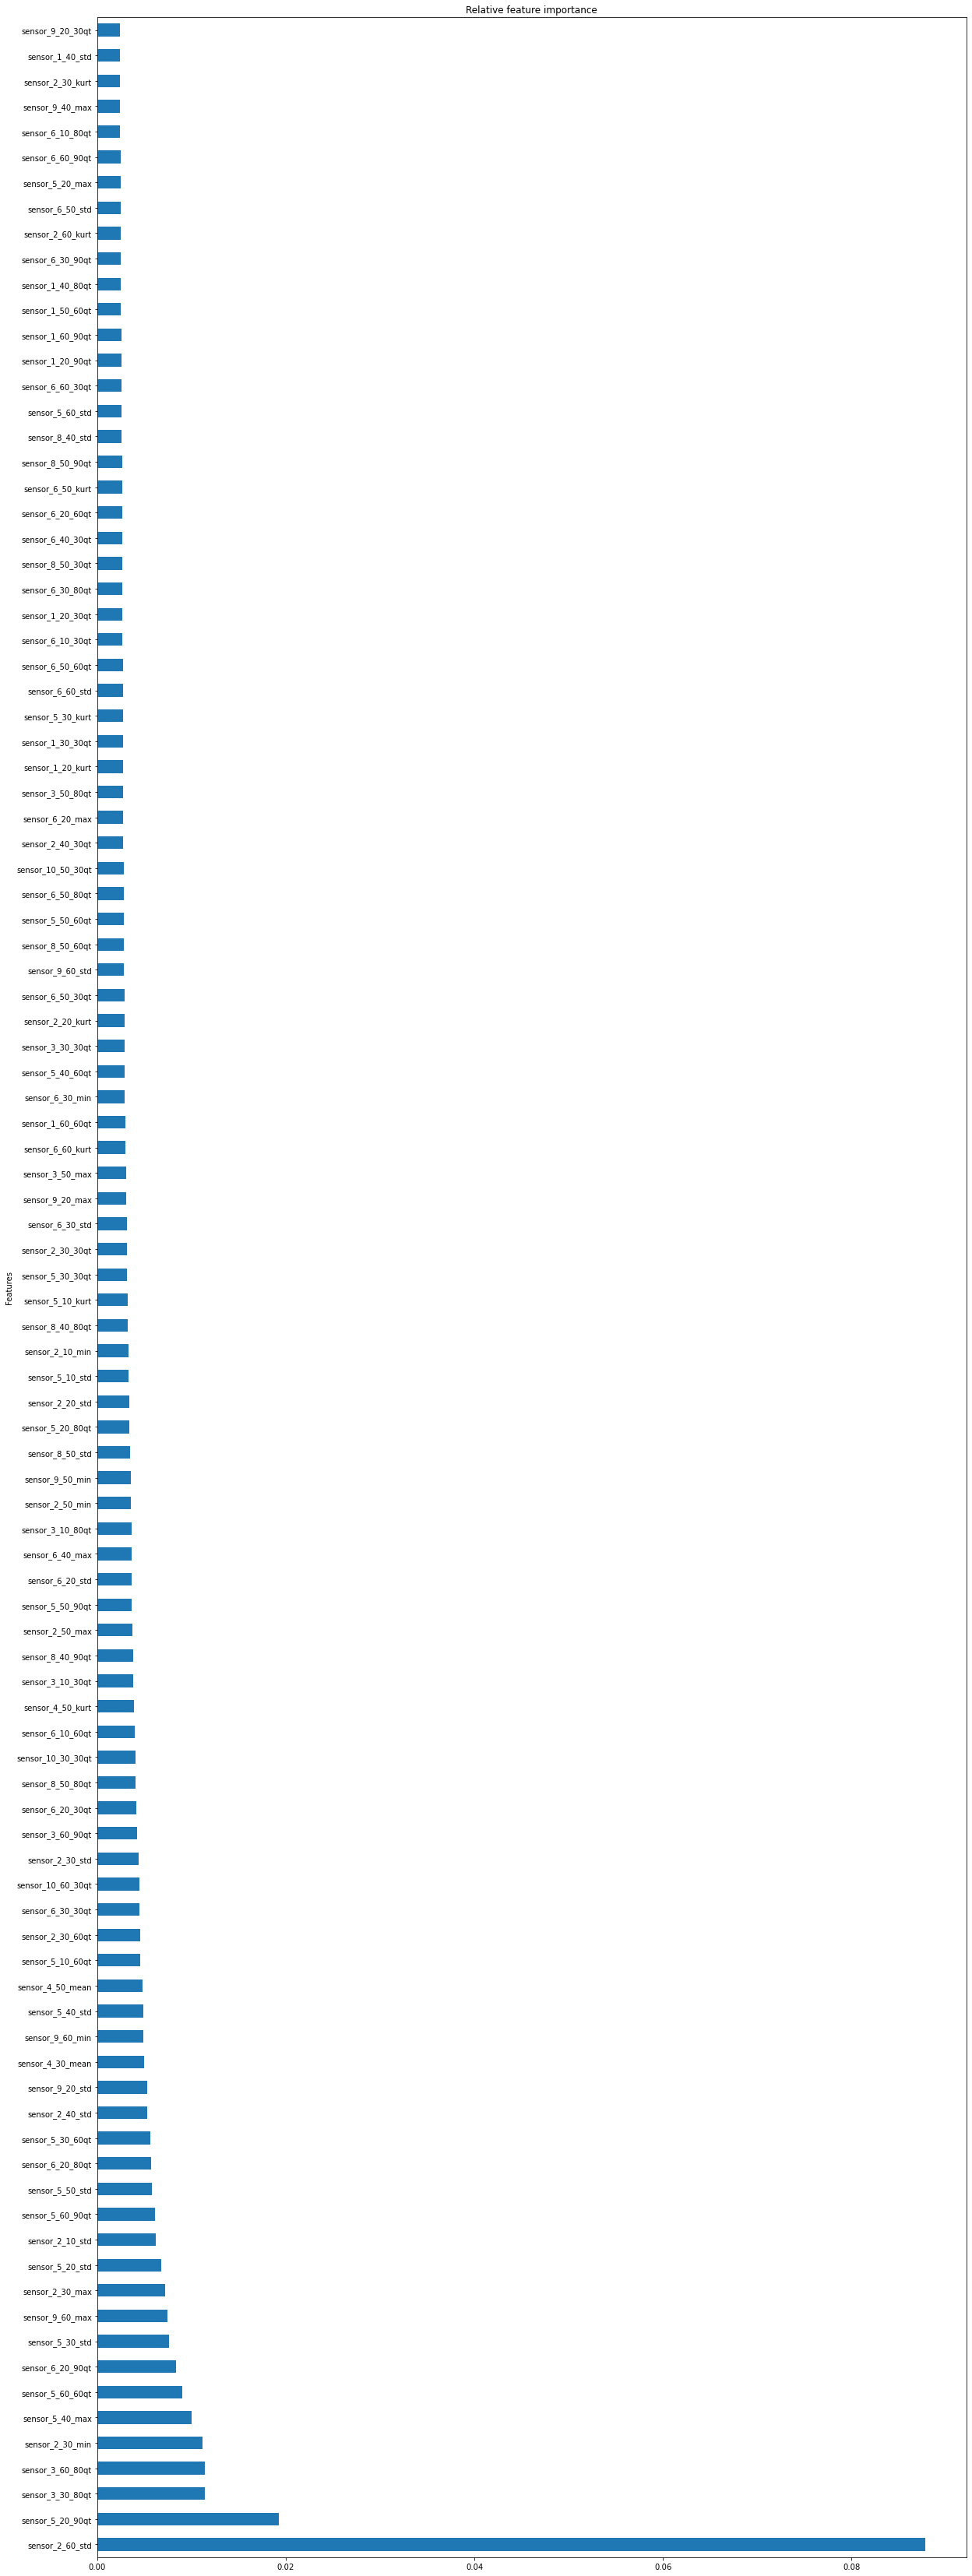

In [95]:
regressor_model = RandomForestRegressor(n_estimators=400)
regressor_model.fit(X,y)
fig, ax = plt.subplots(figsize=(20,60))
pd.Series(regressor_model.feature_importances_, index=X.columns).nlargest(100).plot(kind='barh', ax=ax)
plt.ylabel("Features")
plt.title("Relative feature importance")
plt.show()

The plot above describes the feature importance(relative) wrt RF regressor(with 200 base learners)
* The standard deviation of the sensor_2_60 has much higher importance than rest of the features.
* Majority the skewness kurtosis and mean features has relatively very low importance.
* Since most these features has some degree of importance we can try these features for designing our benchmark model.
* But this time we will discard the mean, kurtosis and skewness features of the given sensor distribution

In [96]:
train_df = pd.read_csv(os.path.join('data','input', 'train.csv'))
train_df.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [5]:
def basic_feature_ts_v2(segment_id_list, test = False):
    """
    This function takes a list of segment ids and returns a pandas DataFrame
    containing various features of the segments namely mean, standard deviation, different quantile values,
    skewness, kurtosis wrt different time windows of each sensor distribution
    Same as v1 but with some minor changes:
    * features namely mean, skewness and kurtosis are not included
    * an option (test) to choose between train/test data has includes
    """ 
    target = 'train' if not test else 'test'
    desc_stat_list = ["{}_{}".format(i,j) 
                      for i in range(10,70,10)
                      for j in ['std', 'min', 'max', '30qt', '60qt', '80qt', '90qt']]
    
    columns = ['sensor_{}_{}'.format(i+1, fea)
              for i in range(10)
              for fea in desc_stat_list]
    
    v2_df = pd.DataFrame(columns=['segment_id'] + columns)
    
    for each_segment in tqdm(segment_id_list):
        
        seg_csv_path = os.path.join('data', 'input', target, str(each_segment)+'.csv')
        seg_df = pd.read_csv(seg_csv_path)
        seg_df = seg_df.fillna(0)
        
        each_row = []
        
        for each_column in seg_df.columns:
            for i in range(6):
                start = i*10000
                end = (i+1)*10000 if i!=5 else None
                
                #each_row.append(seg_df.loc[start:end,:][each_column].mean())
                each_row.append(seg_df.loc[start:end,:][each_column].std())
                each_row.append(seg_df.loc[start:end,:][each_column].min())
                each_row.append(seg_df.loc[start:end,:][each_column].max())
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.3))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.6))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.8))
                each_row.append(seg_df.loc[start:end,:][each_column].quantile(.9))
                #each_row.append(seg_df.loc[start:end,:][each_column].skew())
                #each_row.append(seg_df.loc[start:end,:][each_column].kurt())
        
        v2_df.loc[len(v2_df.index)] = [each_segment] + each_row
        
        v2_df = v2_df.astype({'segment_id' : 'int32'})
    return v2_df

In [5]:
train_df = pd.read_csv(os.path.join('data', 'input', 'train.csv'))
X, y = train_df['segment_id'], train_df['time_to_eruption'].values
basic_feature_wrtt_v2_file = os.path.join('data', 'output', 'segBFTv2.csv')

try:
    X = pd.read_csv(basic_feature_wrtt_v2_file)
except:
    X = basic_feature_ts_v2(X.values)
    X.to_csv(basic_feature_wrtt_v2_file, index=False)

## <h3><font style="font-family:courier;">Machine learning models on basic descriptive features on different time window</font></h3>

The second set of features for given segments has been drawn out. In this section we incorporate various ML models and check the usefullness of the drawn features.

<h4><font style="font-family:courier;">i) Elastic Net</font></h4>
<hr>

In [3]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [4]:
#standardizing data
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_cv_scaled = std_scaler.transform(X_cv)

The MAE for alpha = 1e-06 is 10400111.353701405
The MAE for alpha = 1e-05 is 10473594.386159776
The MAE for alpha = 0.0001 is 10409326.151550677
The MAE for alpha = 0.001 is 10469093.764799878
The MAE for alpha = 0.01 is 10443685.219766514
The MAE for alpha = 0.1 is 10482982.970395872
The MAE for alpha = 1 is 10436639.900523271
The MAE for alpha = 10 is 10625417.514387248
The MAE for alpha = 100 is 11011949.665385485


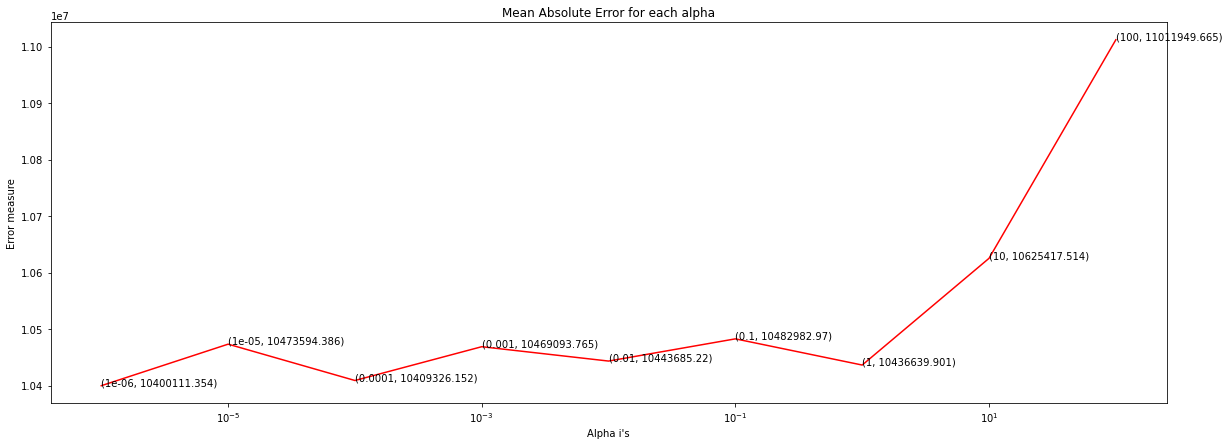

With alpha = 1e-06 the best MAE score we get :
Mean Absolute Error for train data :  10014311.920793638
Mean Absolute Error for cv data :  10440667.000243397


In [5]:
alphas = [10**i for i in range(-6, 3)]
cv_mae_list = []
for each_alpha in alphas:
    en_regr = ElasticNet(l1_ratio=0.6, max_iter=5000, selection='random',tol=1, alpha=each_alpha)
    en_regr.fit(X_train_scaled, y_train)
    preds = en_regr.predict(X_cv_scaled)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for alpha = {} is {}".format(each_alpha, error))

best_alpha = alphas[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(alphas, cv_mae_list, c='r')
ax.set_xscale('log')
for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((alphas[i], txt), (alphas[i], cv_mae_list[i]))
plt.title("Mean Absolute Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

elastic_net_regr = ElasticNet(l1_ratio=0.6, tol=1, max_iter=5000, selection='random', alpha=best_alpha)
elastic_net_regr.fit(X_train_scaled, y_train)
train_preds = elastic_net_regr.predict(X_train_scaled)
cv_preds = elastic_net_regr.predict(X_cv_scaled)
print("With alpha = {} the best MAE score we get :".format(best_alpha))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">ii) Random Forest Regressor</font></h4>
<hr>

In [6]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

The MAE for n_estimator = 100 is 5882893.733190433
The MAE for n_estimator = 200 is 5838409.568693592
The MAE for n_estimator = 300 is 5820737.782833935
The MAE for n_estimator = 400 is 5830880.053662004
The MAE for n_estimator = 500 is 5807111.480521661
The MAE for n_estimator = 600 is 5815340.043176895
The MAE for n_estimator = 700 is 5830317.651373776
The MAE for n_estimator = 800 is 5832433.752465027
The MAE for n_estimator = 900 is 5828960.817527075
The MAE for n_estimator = 1000 is 5845148.099980144


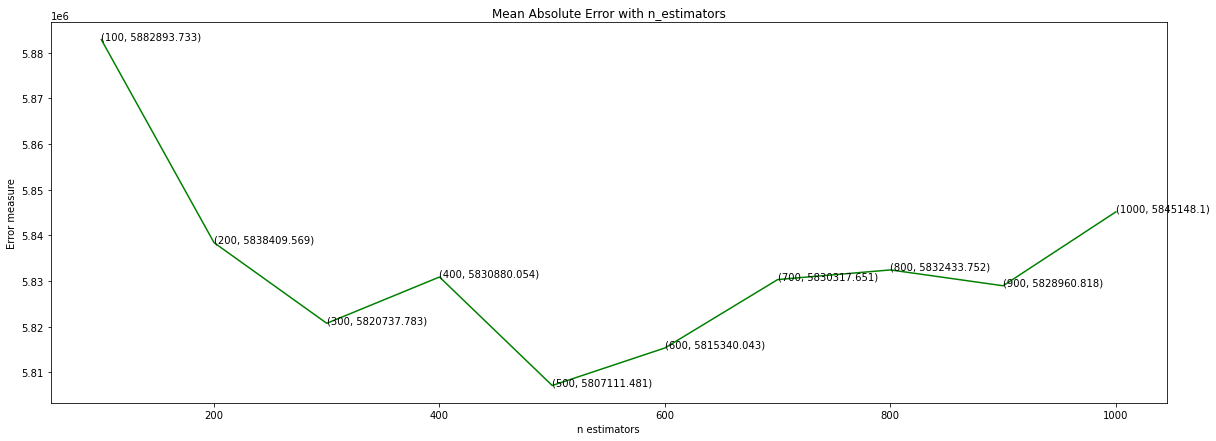

With number of base learners = 500 the best MAE score we get :
Mean Absolute Error for train data :  2134289.1617974723
Mean Absolute Error for cv data :  5790434.270465705


In [7]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    rf_regr = RandomForestRegressor(n_estimators=each_n_est, criterion='mae', n_jobs=-1)
    rf_regr.fit(X_train, y_train)
    preds = rf_regr.predict(X_cv)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

random_forest_regr = RandomForestRegressor(n_estimators=best_n_estimator, criterion='mae', n_jobs=-1)
random_forest_regr.fit(X_train, y_train)
train_preds = random_forest_regr.predict(X_train)
cv_preds = random_forest_regr.predict(X_cv)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">iii) XGBoost Regressor</font></h4>
<hr>

In [6]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

The MAE for n_estimator = 100 is 5686554.648888764
The MAE for n_estimator = 200 is 5680631.025806634
The MAE for n_estimator = 300 is 5679656.414513764
The MAE for n_estimator = 400 is 5679575.896491426
The MAE for n_estimator = 500 is 5679566.5047382675
The MAE for n_estimator = 600 is 5679565.8702617325
The MAE for n_estimator = 700 is 5679565.6399481045
The MAE for n_estimator = 800 is 5679565.460599053
The MAE for n_estimator = 900 is 5679565.280657717
The MAE for n_estimator = 1000 is 5679565.100152302


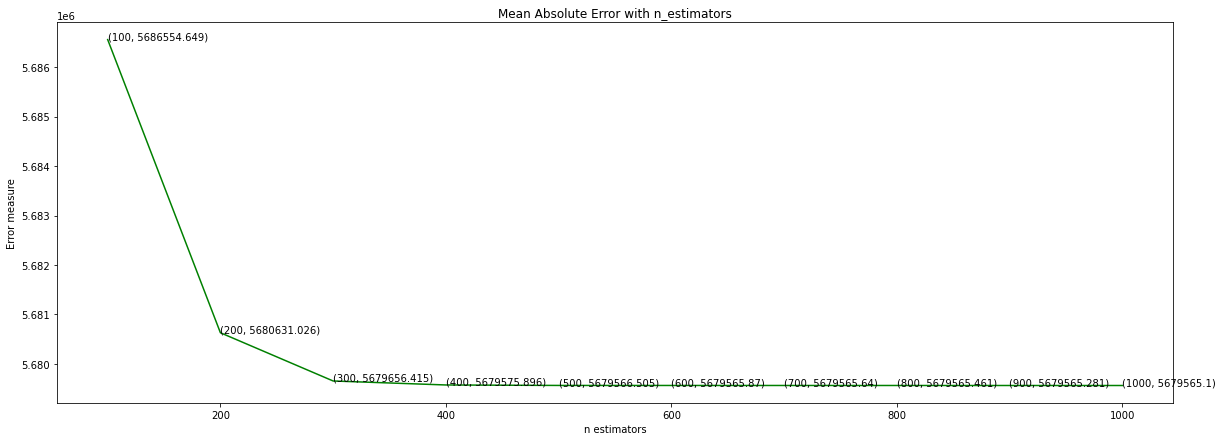

With number of base learners = 1000 the best MAE score we get :
Mean Absolute Error for train data :  3.073164309359013
Mean Absolute Error for cv data :  5679565.100152302


In [7]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    xgb_regr = XGBRegressor(n_estimators=each_n_est, nthread=-2)
    xgb_regr.fit(X_train, y_train)
    preds = xgb_regr.predict(X_cv)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

xg_boost_regr = XGBRegressor(n_estimators=best_n_estimator, nthread=-2)
xg_boost_regr.fit(X_train, y_train)
train_preds = xg_boost_regr.predict(X_train)
cv_preds = xg_boost_regr.predict(X_cv)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

In [5]:
x = PrettyTable()
x.field_names = ['Feature Set','Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['Desc stats','ElasticNet', 10327854.3917, 10470667.9690],
    ['Desc stats','RandomForest', 1625445.1422, 4454705.5167],
    ['Desc stats','XGBoost', 3.1941, 4604529.3528],
    ['Desc stats', 'HPT Random Forest', 4356897.9917,5467757.9835],
    ['Desc stats', 'HPT XGBoost', 19707.4987, 4116339.2665],
    ['','', '' , ''],
    ['Time step Desc stats', 'ElasticNet', 10014311.9208, 10440667.0],
    ['Time step Desc stats', 'RandomForest', 2134289.1618, 5790434.2705],
    ['Time step Desc stats', 'XGBoost', 3.0732, 5679565.1001]
])
print("Summary of ML models :")
print("="*20)
print(x)
print()
print()
print("Note: HPT = hyperparameter Tuned")

Summary of ML models :
+----------------------+-------------------+---------------+----------------+
|     Feature Set      |       Model       |   train_mae   | validation_mae |
+----------------------+-------------------+---------------+----------------+
|      Desc stats      |     ElasticNet    | 10327854.3917 |  10470667.969  |
|      Desc stats      |    RandomForest   |  1625445.1422 |  4454705.5167  |
|      Desc stats      |      XGBoost      |     3.1941    |  4604529.3528  |
|      Desc stats      | HPT Random Forest |  4356897.9917 |  5467757.9835  |
|      Desc stats      |    HPT XGBoost    |   19707.4987  |  4116339.2665  |
|                      |                   |               |                |
| Time step Desc stats |     ElasticNet    | 10014311.9208 |   10440667.0   |
| Time step Desc stats |    RandomForest   |  2134289.1618 |  5790434.2705  |
| Time step Desc stats |      XGBoost      |     3.0732    |  5679565.1001  |
+----------------------+-----------------

The descriptive features wrt time steps didn't contributed in the featurization process, and this can be verified when we compare the MAE scores with previous feature set i.e., only the descriptive features of the time series. Therefore, we didn't conduct any hyperparameter tuning job for the later features.

We will now consider both the feature set and will feed them to a feature selection module and see the optimal number of features that are really helpful in determining the time_to_eruption 

## <h3><font style="font-family:courier;">Machine learning models on above two feature sets</font></h3>

Using the above two feature set we will try to create the first benchmark_model. We will now select some features among all the features and fit different ML algorithms for model comparison

In [2]:
train_df = pd.read_csv(os.path.join('data', 'input', 'train.csv'))
feature_set_1 = pd.read_csv(os.path.join('data','output','segBFv2.csv'))
feature_set_2 = pd.read_csv(os.path.join('data','output','segBFTv2.csv'))

train_df = train_df.merge(feature_set_1, how='left', on='segment_id').merge(feature_set_2, how='left', on='segment_id')

independent_columns = [i for i in train_df.columns if i not in ['segment_id', 'time_to_eruption']]
dependent_column = ['time_to_eruption']
X, y = train_df[independent_columns], np.squeeze(train_df[dependent_column].to_numpy())

<h4><font style="font-family:courier;">Feature Selection</font></h4>
<hr>

In [28]:
# This class RandomForestFeatureSelector has been designed
# to perform feature selection based on RandomForestClassifier's
# feature importances
class RandomForestFeatureSelector():
    
    
    def __init__(self, keep_features=None, n_estimators=100, mode='classify', n_jobs=-1):
        
        self.keep_features = keep_features
        
        if mode=='classify':
            self.clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
        elif mode=='regress':
            self.clf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)
    
    
    def fit(self, X_train, y_train):
        
        if isinstance(X_train, pd.core.frame.DataFrame):
            X_train = X_train.to_numpy()
        
        if isinstance(y_train, (pd.core.frame.DataFrame, pd.core.series.Series)):
            y_train = y_train.to_numpy()
        
        if self.keep_features is None:
            self.keep_features = int(0.5 * X_train.shape[1])
        
        self.clf.fit(X_train, y_train)
        self.imp_feat_ind = np.argsort(self.clf.feature_importances_)[::-1][:self.keep_features]
   
    
    def transform(self, X_data):
        if isinstance(X_data, pd.core.frame.DataFrame):
            X_data = X_data.to_numpy()
        return X_data[:,self.imp_feat_ind]

In [29]:
def optimal_feature_selector(X_train, y_train, n_features_list=[100,200,300], plot_train=False):
    """
    This function takes a list of number of features to consider
    and runs the above RandomForest feature selector on each of the candidate parameters
    and return the best feature selector module. 
    """
    if plot_train:
        tr_mae_list = [] 
    
    cv_mae_list = []
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.15)    
    
    for each_keep_features in tqdm(n_features_list):
        temp_selector = RandomForestFeatureSelector(n_estimators=300, keep_features=each_keep_features, mode='regress', n_jobs=3)
        temp_selector.fit(X_tr,y_tr)
        
        X_tr_fs = temp_selector.transform(X_tr)
        X_cv_fs = temp_selector.transform(X_cv)
        
        temp_regr = RandomForestRegressor(n_estimators=300, criterion='mae', n_jobs=3)
        temp_regr.fit(X_tr_fs, y_tr)
        
        if plot_train:
            tr_preds = temp_regr.predict(X_tr_fs)
            tr_mae_list.append(mae(y_tr, tr_preds))
        
        cv_preds = temp_regr.predict(X_cv_fs)
        cv_mae_list.append(mae(y_cv, cv_preds))
    
    opt_n_features = n_features_list[np.argmin(cv_mae_list)]
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(n_features_list, cv_mae_list, c='b')
    for i, txt in enumerate(np.round(cv_mae_list,3)):
        ax.annotate((n_features_list[i], txt), (n_features_list[i], cv_mae_list[i]))
    
    plt.title("Mean Absolute Error for each n_features")
    plt.xlabel("N_features")
    plt.ylabel("Error measure")
    plt.show()
    
    return RandomForestFeatureSelector(n_estimators=500, keep_features=opt_n_features, mode='regress')
    
         

In [8]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:09:49<00:00, 523.65s/it]


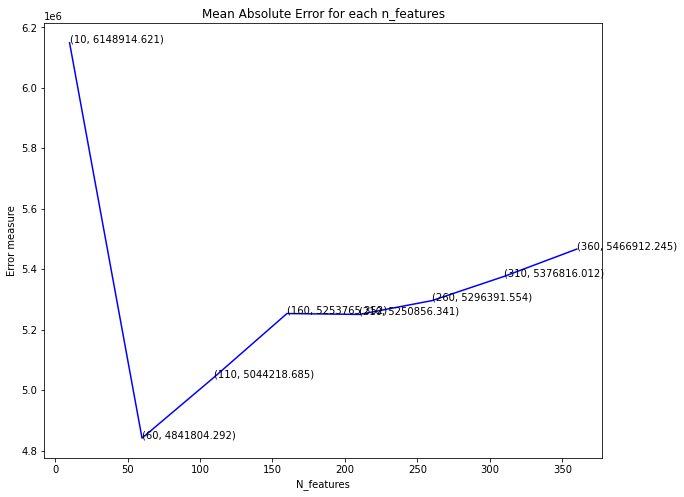

In [18]:
n_features_tcons = [i for i in range(10,400,50)]
fea_select = optimal_feature_selector(X_train, y_train, n_features_list=n_features_tcons)
fea_select.fit(X_train, y_train)
X_train_fs = fea_select.transform(X_train)
X_cv_fs = fea_select.transform(X_cv)

<h4><font style="font-family:courier;">i) Elastic Net</font></h4>
<hr>

In [19]:
#standardizing data
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train_fs)
X_cv_scaled = std_scaler.transform(X_cv_fs)

The MAE for alpha = 1e-06 is 10556155.056897243
The MAE for alpha = 1e-05 is 10447871.934331289
The MAE for alpha = 0.0001 is 10558163.284046153
The MAE for alpha = 0.001 is 10638633.880514199
The MAE for alpha = 0.01 is 10537740.780493634
The MAE for alpha = 0.1 is 10592413.72437556
The MAE for alpha = 1 is 10571808.566030616
The MAE for alpha = 10 is 10784245.926434139
The MAE for alpha = 100 is 11269628.790635051


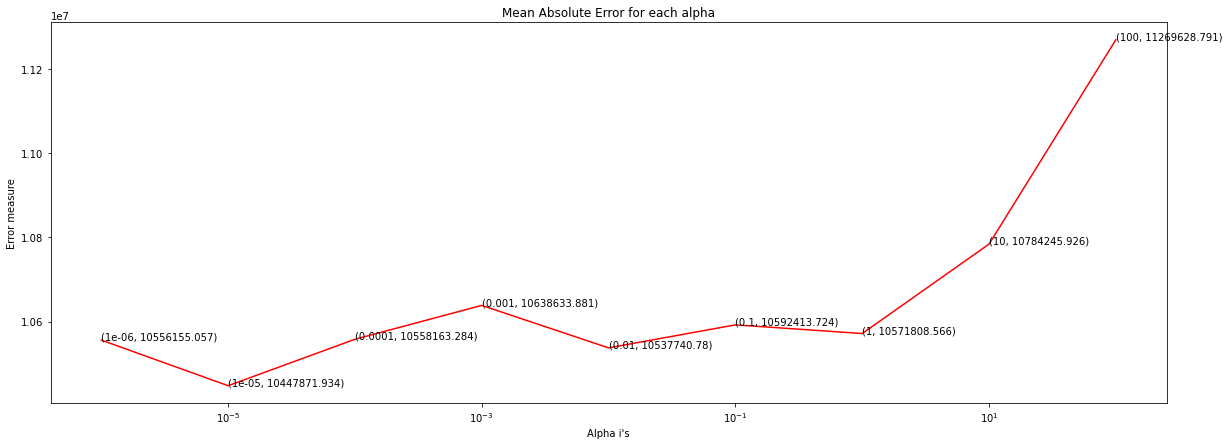

With alpha = 1e-05 the best MAE score we get :
Mean Absolute Error for train data :  10320836.705896234
Mean Absolute Error for cv data :  10534517.246131832


In [20]:
alphas = [10**i for i in range(-6, 3)]
cv_mae_list = []
for each_alpha in alphas:
    en_regr = ElasticNet(l1_ratio=0.6, max_iter=5000, selection='random',tol=1, alpha=each_alpha)
    en_regr.fit(X_train_scaled, y_train)
    preds = en_regr.predict(X_cv_scaled)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for alpha = {} is {}".format(each_alpha, error))

best_alpha = alphas[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(alphas, cv_mae_list, c='r')
ax.set_xscale('log')
for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((alphas[i], txt), (alphas[i], cv_mae_list[i]))
plt.title("Mean Absolute Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

elastic_net_regr = ElasticNet(l1_ratio=0.6, tol=1, max_iter=5000, selection='random', alpha=best_alpha)
elastic_net_regr.fit(X_train_scaled, y_train)
train_preds = elastic_net_regr.predict(X_train_scaled)
cv_preds = elastic_net_regr.predict(X_cv_scaled)
print("With alpha = {} the best MAE score we get :".format(best_alpha))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">ii) Random Forest Regressor</font></h4>
<hr>

In [12]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [13]:
fea_select = RandomForestFeatureSelector(n_estimators=500, keep_features=50, mode='regress')
fea_select.fit(X_train, y_train)
X_train_fs = fea_select.transform(X_train)
X_cv_fs = fea_select.transform(X_cv)

The MAE for n_estimator = 100 is 4551799.054535199
The MAE for n_estimator = 200 is 4583460.283763538
The MAE for n_estimator = 300 is 4538624.797272865
The MAE for n_estimator = 400 is 4544559.643062951
The MAE for n_estimator = 500 is 4569341.55398195
The MAE for n_estimator = 600 is 4596408.939880415
The MAE for n_estimator = 700 is 4560666.102612172
The MAE for n_estimator = 800 is 4545139.010993907
The MAE for n_estimator = 900 is 4556433.503980144
The MAE for n_estimator = 1000 is 4573666.823013538


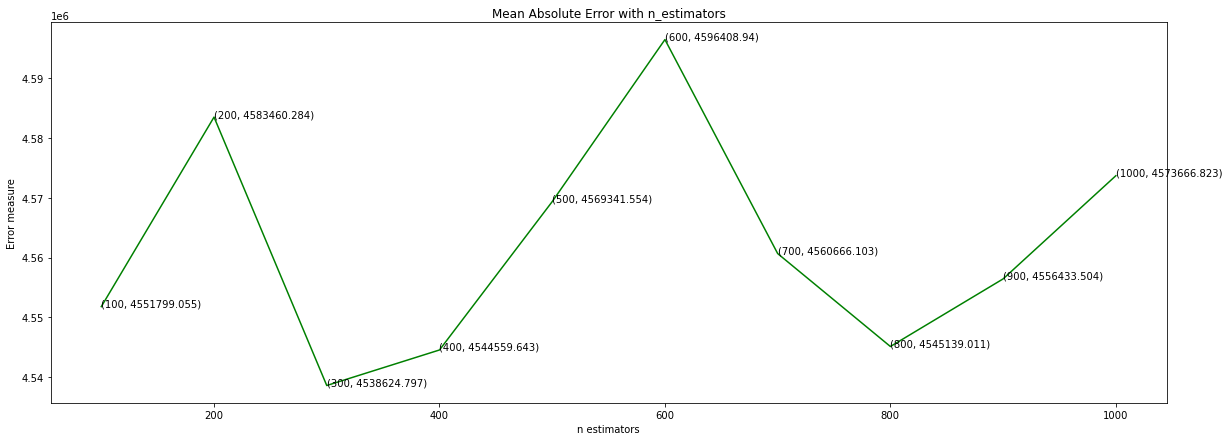

With number of base learners = 300 the best MAE score we get :
Mean Absolute Error for train data :  1652285.8107613602
Mean Absolute Error for cv data :  4591851.245505416


In [22]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    rf_regr = RandomForestRegressor(n_estimators=each_n_est, criterion='mae', n_jobs=-1)
    rf_regr.fit(X_train_fs, y_train)
    preds = rf_regr.predict(X_cv_fs)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

random_forest_regr = RandomForestRegressor(n_estimators=best_n_estimator, criterion='mae', n_jobs=-1)
random_forest_regr.fit(X_train_fs, y_train)
train_preds = random_forest_regr.predict(X_train_fs)
cv_preds = random_forest_regr.predict(X_cv_fs)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

<h4><font style="font-family:courier;">iii) XGBoost Regressor</font></h4>
<hr>

In [14]:
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [15]:
fea_select = RandomForestFeatureSelector(n_estimators=500, keep_features=50, mode='regress')
fea_select.fit(X_train, y_train)
X_train_fs = fea_select.transform(X_train)
X_cv_fs = fea_select.transform(X_cv)

The MAE for n_estimator = 100 is 5171444.729664937
The MAE for n_estimator = 200 is 5143725.715901399
The MAE for n_estimator = 300 is 5140300.343996785
The MAE for n_estimator = 400 is 5139051.4048256995
The MAE for n_estimator = 500 is 5138847.375944833
The MAE for n_estimator = 600 is 5138863.129569043
The MAE for n_estimator = 700 is 5138861.144587658
The MAE for n_estimator = 800 is 5138858.514412229
The MAE for n_estimator = 900 is 5138859.188296762
The MAE for n_estimator = 1000 is 5138860.184432819


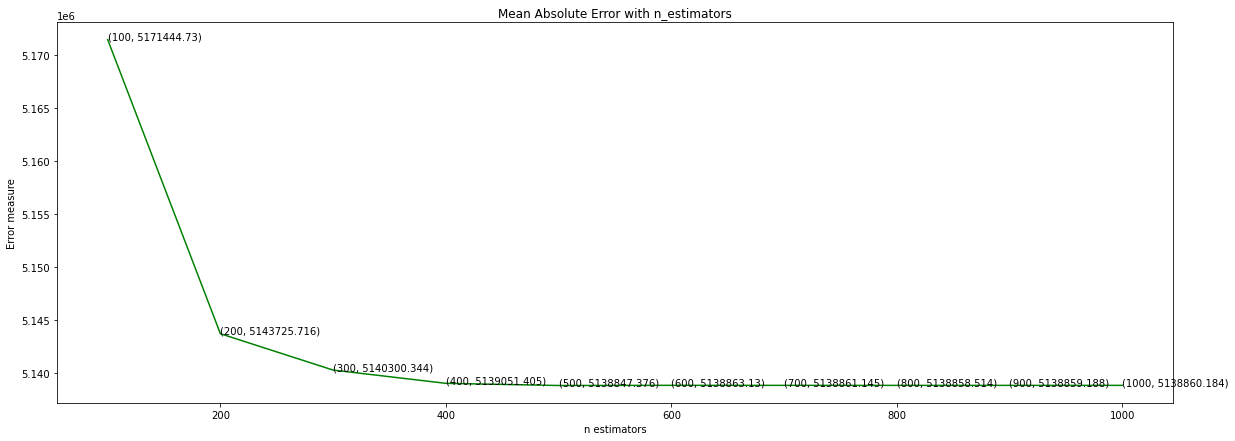

With number of base learners = 500 the best MAE score we get :
Mean Absolute Error for train data :  3131.143756582907
Mean Absolute Error for cv data :  5138847.375944833


In [16]:
n_estimators = [i*100 for i in range(1,11)]
cv_mae_list = []
for each_n_est in n_estimators:
    xgb_regr = XGBRegressor(n_estimators=each_n_est, nthread=-2)
    xgb_regr.fit(X_train_fs, y_train)
    preds = xgb_regr.predict(X_cv_fs)
    error = mae(y_cv, preds)
    cv_mae_list.append(error)
    print("The MAE for n_estimator = {} is {}".format(each_n_est, error))

best_n_estimator = n_estimators[np.argmin(cv_mae_list)]

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(n_estimators, cv_mae_list, c='g')

for i, txt in enumerate(np.round(cv_mae_list,3)):
    ax.annotate((n_estimators[i], txt), (n_estimators[i], cv_mae_list[i]))
plt.title("Mean Absolute Error with n_estimators")
plt.xlabel("n estimators")
plt.ylabel("Error measure")
plt.show()

xg_boost_regr = XGBRegressor(n_estimators=best_n_estimator, nthread=-2)
xg_boost_regr.fit(X_train_fs, y_train)
train_preds = xg_boost_regr.predict(X_train_fs)
cv_preds = xg_boost_regr.predict(X_cv_fs)
print("With number of base learners = {} the best MAE score we get :".format(best_n_estimator))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

In [6]:
x = PrettyTable()
x.field_names = ['Feature Set','Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['Desc stats','ElasticNet', 10327854.3917, 10470667.9690],
    ['Desc stats','RandomForest', 1625445.1422, 4454705.5167],
    ['Desc stats','XGBoost', 3.1941, 4604529.3528],
    ['Desc stats', 'HPT Random Forest', 4356897.9917,5467757.9835],
    ['Desc stats', 'HPT XGBoost', 19707.4987, 4116339.2665],
    ['','', '' , ''],
    ['Time step Desc stats', 'ElasticNet', 10014311.9208, 10440667.0],
    ['Time step Desc stats', 'RandomForest', 2134289.1618, 5790434.2705],
    ['Time step Desc stats', 'XGBoost', 3.0732, 5679565.1001],
    ['','', '' , ''],
    ['Selected Desc stats features','ElasticNet', 10320836.7059, 10534517.2461],
    ['Selected Desc stats features','RandomForest', 1652285.8108, 4591851.2455],
    ['Selected Desc stats features','XGBoost', 3131.1438, 5138847.3759],
])
print("Summary of ML models :")
print("="*20)
print(x)
print()
print()
print("Note: HPT = hyperparameter Tuned")


Summary of ML models :
+------------------------------+-------------------+---------------+----------------+
|         Feature Set          |       Model       |   train_mae   | validation_mae |
+------------------------------+-------------------+---------------+----------------+
|          Desc stats          |     ElasticNet    | 10327854.3917 |  10470667.969  |
|          Desc stats          |    RandomForest   |  1625445.1422 |  4454705.5167  |
|          Desc stats          |      XGBoost      |     3.1941    |  4604529.3528  |
|          Desc stats          | HPT Random Forest |  4356897.9917 |  5467757.9835  |
|          Desc stats          |    HPT XGBoost    |   19707.4987  |  4116339.2665  |
|                              |                   |               |                |
|     Time step Desc stats     |     ElasticNet    | 10014311.9208 |   10440667.0   |
|     Time step Desc stats     |    RandomForest   |  2134289.1618 |  5790434.2705  |
|     Time step Desc stats     

Note that, if we consider model performance (keeping in mind the overfitting issue) :
* we can see that the Hyperparameter tuned RandomForest model is performing well on the data with just basic descriptive features
* the RandomForest on selected features is also performing well on the validation set but is overfitting the training set
* Hence we will try to hyperparameter tune this model on the selected features

<h4><font style="font-family:courier;">Hyperparameter Tuning Random Forest Model</font></h4>
<hr>

In [4]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=29)

In [8]:
fea_select = RandomForestFeatureSelector(n_estimators=500, keep_features=50, mode='regress')
fea_select.fit(X_train, y_train)
X_train_fs = fea_select.transform(X_train)
X_cv_fs = fea_select.transform(X_cv)

In [14]:
with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(fea_select, f)

In [7]:
rf_regr = RandomForestRegressor(criterion='mae')
prams={
    'n_estimators' : [i for i in range(800, 2000, 100)],
    'max_depth' : [i for i in range(5,20)],
    'min_samples_split' : [i for i in range(10,20)],
    'min_samples_leaf' : [i for i in range(4,12)],
    'max_features' : [0.1*i for i in range(5, 10)],
    'max_samples' : [0.1*i for i in range(5, 10)]
}
cv = RepeatedKFold(n_repeats=2)
random_search_cv=RandomizedSearchCV(rf_regr, param_distributions=prams, cv=cv,verbose=10, n_jobs=3,)
random_search_cv.fit(X_train_fs, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  9.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 13.9min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 25.5min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 60.9min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 97.5min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 120.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 142.6min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 164.8min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 208.2min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 240.0min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 262.0min finished


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fractio...
                                

In [8]:
with open('rf_model_all_rscv.pkl', 'wb') as f:
    pickle.dump(random_search_cv, f)

In [9]:
with open('rf_model_all_rscv.pkl', 'rb') as f:
    random_search_cv = pickle.load(f)

In [11]:
random_forest_regr = random_search_cv.best_estimator_
random_forest_regr.fit(X_train_fs, y_train)
train_preds = random_forest_regr.predict(X_train_fs)
cv_preds = random_forest_regr.predict(X_cv_fs)
print("For hyperparameter tuned RandomForestRegressor with parameters :")
print(random_search_cv.best_params_)
print()
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

For hyperparameter tuned RandomForestRegressor with parameters :
{'n_estimators': 900, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 0.7000000000000001, 'max_depth': 12}

Mean Absolute Error for train data :  4034030.3299535224
Mean Absolute Error for cv data :  5356034.492861512


In [16]:
best_estimator = random_search_cv.best_estimator_
with open('rf_best_estimator.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)

In [7]:
x = PrettyTable()
x.field_names = ['Feature Set','Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['Desc stats','ElasticNet', 10327854.3917, 10470667.9690],
    ['Desc stats','RandomForest', 1625445.1422, 4454705.5167],
    ['Desc stats','XGBoost', 3.1941, 4604529.3528],
    ['Desc stats', 'HPT Random Forest', 4356897.9917,5467757.9835],
    ['Desc stats', 'HPT XGBoost', 19707.4987, 4116339.2665],
    ['','', '' , ''],
    ['Time step Desc stats', 'ElasticNet', 10014311.9208, 10440667.0],
    ['Time step Desc stats', 'RandomForest', 2134289.1618, 5790434.2705],
    ['Time step Desc stats', 'XGBoost', 3.0732, 5679565.1001],
    ['','', '' , ''],
    ['Selected Desc stats features','ElasticNet', 10320836.7059, 10534517.2461],
    ['Selected Desc stats features','RandomForest', 1652285.8108, 4591851.2455],
    ['Selected Desc stats features','XGBoost', 3131.1438, 5138847.3759],
    ['Selected Desc stats features', 'HPT Random Forest', 4034030.33,5356034.4929]
])
print("Summary of ML models :")
print("="*20)
print(x)
print()
print()
print("Note: HPT = hyperparameter Tuned")

Summary of ML models :
+------------------------------+-------------------+---------------+----------------+
|         Feature Set          |       Model       |   train_mae   | validation_mae |
+------------------------------+-------------------+---------------+----------------+
|          Desc stats          |     ElasticNet    | 10327854.3917 |  10470667.969  |
|          Desc stats          |    RandomForest   |  1625445.1422 |  4454705.5167  |
|          Desc stats          |      XGBoost      |     3.1941    |  4604529.3528  |
|          Desc stats          | HPT Random Forest |  4356897.9917 |  5467757.9835  |
|          Desc stats          |    HPT XGBoost    |   19707.4987  |  4116339.2665  |
|                              |                   |               |                |
|     Time step Desc stats     |     ElasticNet    | 10014311.9208 |   10440667.0   |
|     Time step Desc stats     |    RandomForest   |  2134289.1618 |  5790434.2705  |
|     Time step Desc stats     

After hyperparameter tuning the performance on the validation set has detoriated but the issue of overfitting has been mitigated to a great extent. But if we judge the model performance on the basis of the following factors:
* fitting the train set
* model performance on validation set

We think both HPT RandomForest, for Desc stats feature set & Selected Desc stats feature set, serves as a good benchmark. So we will consider them both for now 

In the next section we define whole pipeline such that the predictions for the test data can be obtained by invoking those pipeline. 

In [6]:
def benchmark_pipeline_hrfds(segment_id_list, test=True):
    """
    This function takes a list of segment ids can generates predictions.
    It creates the basic descriptive features of the timeseries, and then
    predicts the outcome for the obtained data.
    This function also returns the time taken to complete the whole process
    """
    start = time.time()
    
    test_df = basic_feature_v2(segment_id_list, test=test)
    
    with open('rf_model_bfv2.pkl', 'rb') as f:
        best_estimator = pickle.load(f)
        
    
    preds = best_estimator.predict(test_df)
    
    duration = time.time() - start
    return preds, duration

In [7]:
def benchmark_pipeline_hrfsf(segment_id_list):
    """
    This function takes a list of segment ids can generates predictions.
    It creates the basic descriptive features of the timeseries as feature set 1,
    next creates the descriptive stats wrt different timewindow abd merge them together.
    After that it selects the useful features through the feature selector module and
    predicts the outcome for the obtained data.
    This function also returns the time taken to complete the whole process
    """
    
    start = time.time()
    
    f1_set = basic_feature_v2(segment_id_list, test=True)
    f2_set = basic_feature_ts_v2(segment_id_list, test=True)
    
    test_df = f1_set.merge(f2_set, how='left', on='segment_id')
    
    with open('feature_selector.pkl', 'rb') as f:
        fea_select = pickle.load(f)
    
    with open('rf_best_estimator.pkl', 'rb') as f:
        best_estimator = pickle.load(f)
    
    test_transformed = fea_select.transform(test_df)
    
    preds = best_estimator.predict(test_transformed)
    
    duration = time.time() - start
    return preds, duration

#### Benchmark Testing

In [8]:
#loading the test_segment_ids from the sample submission file
test_data = pd.read_csv(os.path.join('data', 'input', 'sample_submission.csv'))
test_data.head()

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


##### Model 1:

In [20]:
#candidate model 1 hyperparameter tuned RandomForest on basic descriptive statistics of the time series
preds, duration = benchmark_pipeline_hrfds(test_data['segment_id'].values)
test_data['time_to_eruption'] = preds
print("Time taken to obtain the test predictions : {} seconds".format(duration))
print("First few rows of the test data :")
test_data.head()

100%|██████████████████████████████████████████████████████████████████████████████| 4520/4520 [13:04<00:00,  5.76it/s]


Time taken to obtain the test predictions : 784.852237701416 seconds
First few rows of the test data :


,segment_id,time_to_eruption
0,1000213997,2.231834e+07
1,100023368,3.178813e+07
2,1000488999,2.931988e+07
3,1001028887,2.468291e+07
4,1001857862,2.051072e+07


In [21]:
#creating submission file for kaggle 
submission_file = os.path.join("data", "output", "submission_benchmark_M1.csv")
test_data.to_csv(submission_file, index=False)

##### Model 2:

In [31]:
#candidate model 2 hyperparameter tuned RandomForest on selected (from both basic and wrt time window) descriptive statistics of the time series
preds, duration = benchmark_pipeline_hrfsf(test_data['segment_id'].values)
test_data['time_to_eruption'] = preds
print("Time taken to obtain the test predictions : {} seconds".format(duration))
print("First few rows of the test data :")
test_data.head()

100%|██████████████████████████████████████████████████████████████████████████████| 4520/4520 [30:29<00:00,  2.47it/s]


Time taken to obtain the test predictions : 2649.2711565494537 seconds
First few rows of the test data :


,segment_id,time_to_eruption
0,1000213997,2.580180e+07
1,100023368,2.438469e+07
2,1000488999,2.485290e+07
3,1001028887,2.415536e+07
4,1001857862,2.394713e+07


In [32]:
#creating submission file for kaggle 
submission_file = os.path.join("data", "output", "submission_benchmark_M2.csv")
test_data.to_csv(submission_file, index=False)

#### Screenshot of kaggle scores
![benchmark kaggle scores](data\images\bm_kscore.JPG)

* By considering, the time taken to generate predictions for the test set and performance score generated by Kaggle, Model_1 has a better performance
* Hence we will choose Model_1 (Basic Descriptive Features + RandomForestRegressor) as benchmark/baseline

#### Discussions

* In this case study, we had oppurtunity to get our hands on seismic data provided INGV through kaggle
* We had basically, two sets of data: train(4431) and test(4520), consisting of data recorded over 10 sensors
* First, we have drawn features such as minimum, maximum and other distribution properties of each of the sensor distributions for each datapoint
* Another set of similar features (but this time number of features were more because instead of drawing the features from whole sensor distribution, we were collecting them on the basis of smaller time window) were drawn in the next sections
* After that, mainly three (Elastic Net, Random Forest, XGBoost) ML algorithms was applied on on the combination of two sets featurization and performance was compared.
* Lastly, one model has been chosen as benchmark/baseline and its performance is recorded for future reference and model selection & validation


#### Experimenting with custom stacking ensemble model (benchmark features)

In [2]:
train_df = pd.read_csv(os.path.join('data', 'input', 'train.csv'))
feature_set = pd.read_csv(os.path.join('data','output','segBFv2.csv'))

train_df = train_df.merge(feature_set, how='left', on='segment_id')

independent_columns = [i for i in train_df.columns if i not in ['segment_id', 'time_to_eruption']]
dependent_column = ['time_to_eruption']
X, y = train_df[independent_columns], np.squeeze(train_df[dependent_column].to_numpy())

In [3]:
#train test split 
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=29)

In [5]:
class EnsembleRegressor():  
    """
    This module implements a custom ensemble model.
    The training procedure on train set is as follows:
        * splits the train set into D1 and D2.(50-50)
        * now from this D1 sampling is done with replacement 
          to create d1,d2,d3....dk(k samples)
        * k DecisionTree models are now trained on each of these k samples
        (k can be considered as a hyperparameter)
        * now the set aside D2 is passed to the k trained models to obtain a k-dimensional feature set
        * with the help of these feature set along with D2 targets, a metalearner is trained
          which is also a decision tree. This metalearner is our actual model and rest of the base just
          baselearner can be considered as feature extractors
    """
    
    def __init__(self, n_learners = 10, meta_learner = None, oob_size=0.5, max_sample_ratio=None, meta_rs=False, meta_params=None):
        self.n_learners = n_learners
        self.oob_size = oob_size
        self.max_samples = max_samples_ratio if max_sample_ratio is not None else 0.2
        self.tree_list = [DecisionTreeRegressor() for i in range(self.n_learners)]
        
        self.meta_rs = meta_rs
        
        
        
        if meta_learner is None or meta_learner == 'decision_tree':
            self.meta_learner = DecisionTreeRegressor()
        elif meta_learner == 'random_forest':
            self.meta_learner = RandomForestRegressor()
        elif meta_learner == 'xgboost':
            self.meta_learner = XGBRegressor()
        elif meta_learner == 'svr':
            self.meta_learner = SVR()
        elif meta_learner == 'kernel_ridge':
            self.meta_learner = KernelRidge()
        elif meta_learner == 'bayesian_ridge':
            self.meta_learner = BayesianRidge()
            
        if self.meta_rs:
            if not isinstance(meta_params, dict):
                raise ValueError("Hyperparameter Search Mode requires a dictionary of parameters")
            else:
                self.meta_params = meta_params
                self.rs_obj = RandomizedSearchCV(self.meta_learner, self.meta_params, cv=5, n_iter=3, n_jobs=3)
            
        return None
    
    
    def _create_sample(self,X,y,fraction):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        indices = random.sample(range(len(X)), int(fraction*len(X)))
        return X[indices], y[indices]
    
    def fit(self, X, y):
        
        X_D1, X_D2, y_D1, y_D2 = train_test_split(X,y,test_size=self.oob_size)
        
        D2_predlist = []
        
        for i in range(self.n_learners):
            X_temp, y_temp = self._create_sample(X_D1, y_D1, self.max_samples)
            self.tree_list[i].fit(X_temp, y_temp)
            preds = self.tree_list[i].predict(X_D2)
            
            D2_predlist.append(preds)
        
        new_feature_set = np.stack(D2_predlist, axis=1)
        
        if self.meta_rs:
            self.rs_obj.fit(new_feature_set, y_D2)
            self.meta_learner = self.rs_obj.best_estimator_
        
        self.meta_learner.fit(new_feature_set, y_D2)
        return self
        
    def predict(self, X):
        
        D2_predlist = []
        
        for i in range(self.n_learners):
            preds = self.tree_list[i].predict(X)    
            D2_predlist.append(preds)
        
        new_feature_set = np.stack(D2_predlist, axis=1)
        return self.meta_learner.predict(new_feature_set) 
        

##### Custom Ensemble Model for different meta learner algorithm with different number of base learners 

In [10]:
n_estimators = [i*100 for i in range(1,21)]
meta_learners = ['decision_tree', 'random_forest', 'xgboost', 'svr', 'kernel_ridge', 'bayesian_ridge']
cv_mae_list = []

for each_meta in meta_learners:
    print("Meta Learner : {}".format(each_meta))
    print('-'*30)
    for each_n_est in n_estimators:
        custom_regr = EnsembleRegressor(meta_learner=each_meta, n_learners=each_n_est)
        custom_regr.fit(X_train, y_train)
        preds = custom_regr.predict(X_cv)
        error = mae(y_cv, preds)
        cv_mae_list.append(error)
        print("The MAE for n_estimator = {} is {}".format(each_n_est, error))
    print()

    
best_arg = np.argmin(cv_mae_list)

best_n_estimator = n_estimators[int(best_arg%len(n_estimators))]
best_meta = meta_learners[int(best_arg/len(n_estimators))]


cust_ensemble_regr = EnsembleRegressor(meta_learner=best_meta,n_learners=best_n_estimator)
cust_ensemble_regr.fit(X_train, y_train)
train_preds = cust_ensemble_regr.predict(X_train)
cv_preds = cust_ensemble_regr.predict(X_cv)
print("With number of base learners = {} and with meta_learner = {} the best MAE score we get :".format(best_n_estimator, best_meta))
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

Meta Learner : decision_tree
------------------------------
The MAE for n_estimator = 100 is 7556173.962795941
The MAE for n_estimator = 200 is 6758790.969560316
The MAE for n_estimator = 300 is 7182734.04735062
The MAE for n_estimator = 400 is 7262099.317925592
The MAE for n_estimator = 500 is 7277493.056369786
The MAE for n_estimator = 600 is 6896013.254791432
The MAE for n_estimator = 700 is 7047319.720405863
The MAE for n_estimator = 800 is 6679991.741826381
The MAE for n_estimator = 900 is 7149556.367531003
The MAE for n_estimator = 1000 is 6557581.139797069
The MAE for n_estimator = 1100 is 6786803.278466742
The MAE for n_estimator = 1200 is 7035674.145434047
The MAE for n_estimator = 1300 is 6791160.556933484
The MAE for n_estimator = 1400 is 6871807.571589628
The MAE for n_estimator = 1500 is 6614727.077790304
The MAE for n_estimator = 1600 is 6990620.997745208
The MAE for n_estimator = 1700 is 6664771.273957159
The MAE for n_estimator = 1800 is 6655158.246899662
The MAE for n_

c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 100 is 6220795.719278467


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 200 is 6265064.990980835


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 300 is 6406645.922209696


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 400 is 6207028.391206314


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 500 is 6499855.895152198


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 600 is 6544291.570462232


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 700 is 6834155.26042841


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 800 is 6808544.267192785


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 900 is 7116138.565952649


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1000 is 7834598.89740699


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1100 is 7835739.710259301


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1200 is 8731722.594137542


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1300 is 9788954.667700112


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1400 is 10417211.734339837


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1500 is 13153224.954981193


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1600 is 15310052.249154454


c:\users\soumy\anaconda3\envs\tf2_env\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


The MAE for n_estimator = 1700 is 20472636.32581736
The MAE for n_estimator = 1800 is 32266121.172343474
The MAE for n_estimator = 1900 is 17534076.434185445
The MAE for n_estimator = 2000 is 13368365.938254625

Meta Learner : bayesian_ridge
------------------------------
The MAE for n_estimator = 100 is 6036342.441462971
The MAE for n_estimator = 200 is 5689963.4354745075
The MAE for n_estimator = 300 is 5703616.309704223
The MAE for n_estimator = 400 is 5699873.312131442
The MAE for n_estimator = 500 is 5420546.420344247
The MAE for n_estimator = 600 is 5543344.687854803
The MAE for n_estimator = 700 is 5425167.956423726
The MAE for n_estimator = 800 is 5645784.490925035
The MAE for n_estimator = 900 is 5237429.277899121
The MAE for n_estimator = 1000 is 5188622.686763408
The MAE for n_estimator = 1100 is 5208888.720678024
The MAE for n_estimator = 1200 is 5326538.479053321
The MAE for n_estimator = 1300 is 5110682.821496914
The MAE for n_estimator = 1400 is 5136511.864700923
The MAE

#### Custom Ensemble Model :  meta learner xgboost

In this section we will fix the number of base learners to 1300 and apply grid search on the meta learner

In [7]:
params = {
        'min_child_weight': [i for i in range(5,11,2)],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [i for i in range(3,21,2)],
        'n_estimators': [i*100 for i in range(1,21)]
        }
cust_boost_regr = EnsembleRegressor(n_learners=1300, meta_learner='xgboost', meta_rs=True, meta_params=params)
cust_boost_regr.fit(X_train, y_train)
train_preds = cust_boost_regr.predict(X_train)
cv_preds = cust_boost_regr.predict(X_cv)
print("With number of base learners = 1300 and meta learner = xgboost the best MAE score we get :")
print("Mean Absolute Error for train data : ", mae(y_train, train_preds))
print("Mean Absolute Error for cv data : ", mae(y_cv, cv_preds))

With number of base learners = 1300 and meta learner = xgboost the best MAE score we get :
Mean Absolute Error for train data :  1992397.2213964183
Mean Absolute Error for cv data :  5385850.012225198


In [9]:
x = PrettyTable()
x.field_names = ['Feature Set','Model', 'train_mae', 'validation_mae']
x.add_rows([
    ['Desc stats','ElasticNet', 10327854.3917, 10470667.9690],
    ['Desc stats','RandomForest', 1625445.1422, 4454705.5167],
    ['Desc stats','XGBoost', 3.1941, 4604529.3528],
    ['Desc stats', 'HPT Random Forest', 4356897.9917,5467757.9835],
    ['Desc stats', 'HPT XGBoost', 19707.4987, 4116339.2665],
    ['','', '' , ''],
    ['Time step Desc stats', 'ElasticNet', 10014311.9208, 10440667.0],
    ['Time step Desc stats', 'RandomForest', 2134289.1618, 5790434.2705],
    ['Time step Desc stats', 'XGBoost', 3.0732, 5679565.1001],
    ['','', '' , ''],
    ['Selected Desc stats features','ElasticNet', 10320836.7059, 10534517.2461],
    ['Selected Desc stats features','RandomForest', 1652285.8108, 4591851.2455],
    ['Selected Desc stats features','XGBoost', 3131.1438, 5138847.3759],
    ['Selected Desc stats features', 'HPT Random Forest', 4034030.33,5356034.4929],
    ['','', '' , ''],
    ['Desc stats','HPT Custom Ensemble', 1992397.2214, 5385850.0122]
])
print("Summary of ML models :")
print("="*20)
print(x)
print()
print()
print("Note: HPT = hyperparameter Tuned")

Summary of ML models :
+------------------------------+---------------------+---------------+----------------+
|         Feature Set          |        Model        |   train_mae   | validation_mae |
+------------------------------+---------------------+---------------+----------------+
|          Desc stats          |      ElasticNet     | 10327854.3917 |  10470667.969  |
|          Desc stats          |     RandomForest    |  1625445.1422 |  4454705.5167  |
|          Desc stats          |       XGBoost       |     3.1941    |  4604529.3528  |
|          Desc stats          |  HPT Random Forest  |  4356897.9917 |  5467757.9835  |
|          Desc stats          |     HPT XGBoost     |   19707.4987  |  4116339.2665  |
|                              |                     |               |                |
|     Time step Desc stats     |      ElasticNet     | 10014311.9208 |   10440667.0   |
|     Time step Desc stats     |     RandomForest    |  2134289.1618 |  5790434.2705  |
|     Tim

In [8]:
#saving model to disk
with open('custEnsemblexgb.pkl', 'wb') as f:
    pickle.dump(cust_boost_regr, f)

#### Hyperparameter tuning the Custom Ensemble

We will check the performance of the above designed custom model with different sets of hyperparameters. The hyperparameters that will be considered are the number of base estimators, meta learning algorithm and the hyperparameters of the meta learner itself. 

In [12]:
#custom ensemble prediction pipeline
def pipeline_customensemble(segment_id_list, test=True):
    """
    This function takes a list of segment ids can generates predictions.
    It creates the basic descriptive features of the timeseries, and then
    predicts the outcome for the obtained data.
    This function also returns the time taken to complete the whole process
    """
    start = time.time()
    
    test_df = basic_feature_v2(segment_id_list, test=test)
    
    with open('custEnsemblexgb.pkl', 'rb') as f:
        best_estimator = pickle.load(f)
        
    
    preds = best_estimator.predict(test_df.drop('segment_id', axis=1))
    
    duration = time.time() - start
    return preds, duration

In [13]:
#loading the test_segment_ids from the sample submission file
test_data = pd.read_csv(os.path.join('data', 'input', 'sample_submission.csv'))
test_data.head()

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


In [16]:
#custom model on the test set
preds, duration = pipeline_customensemble(test_data['segment_id'].values)
test_data['time_to_eruption'] = preds
print("Time taken to obtain the test predictions : {} seconds".format(duration))
print("First few rows of the test data :")
test_data.head()

100%|██████████████████████████████████████████████████████████████████████████████| 4520/4520 [14:19<00:00,  5.26it/s]


Time taken to obtain the test predictions : 864.2267129421234 seconds
First few rows of the test data :


,segment_id,time_to_eruption
0,1000213997,19889702.0
1,100023368,39146452.0
2,1000488999,28263206.0
3,1001028887,21337880.0
4,1001857862,22331944.0


In [17]:
#creating submission file for kaggle 
submission_file = os.path.join("data", "output", "submission_custom_ensemblexgb.csv")
test_data.to_csv(submission_file, index=False)

#### Screenshot of kaggle scores
![benchmark kaggle scores](data\images\cenx_kscore.JPG)


The performance of the custom model is lower than our designed benchmark. Though it performing well on train data, but the difference in performance of the validation is sign of overfitting. The duration taken by the model to obtain test predictions is lower than our benchmark. However, considering the kaggle score we cannot take into account a model that has lower benchmark performance. 

#### Discussions
* We should consider rich feature engineering techniques, such as transforming time domain to frequency domain. And also consider opensource libraries like tsfresh to draw features that are relevant for time series data
* We should also try more complex modelling techniques (like ANNs)
* We look for some pre-trained networks, for feature extraction, that are already capable of accomplising similar task related to time series data